# ARMA
- Carlota Julià: carlota.julia01@estudiant.upf.edu
- Klaus Ditterich: klaus.ditterich01@estudiant.upf.edu
- Marta Alet: marta.alet01@estudiant.upf.edu
- Nasar Roca: nasar.roca01@estudiant.upf.edu
- Rafael Bardisa: rafael.bardisa01@estudiant.upf.edu

## Introducció
Som un grup de estudiants de la Universitat Pompeu Fabra, i aquesta és la nostra Notebook del projecte que hem fet per AGBAR.

En aquesta notebook trobem el desenvolupament d'un model predictiu sobre el consum d'aigua, recolzat amb variables de dades obertes i utilitzant el fet que el consum esta condicionat pel factors externs.

La motivació rere aquest projecte comença amb el plantejament de la crisi del recurs de l'aigua. Durant el darrer any hem experimentat un període de sequera, bastant més crític que en els darrers 5 anys; les reserves naturals es troben al 35% de la seva capacitat i les desalinitzadores han hagut de començar a funcionar a màxima capacitat.

Amb el nostre model volem ajudar a obtenir una predicció del consum de l'aigua en un futur proper. Aleshores utilitzar aquestes prediccions per una millor gestió del recurs, podent així estalviar aigua. Això significaria un impacte beneficiari tant medioambiental com econòmic: no haver de dependre tant de les dessalinitzadores reduiria el cost econòmic i també energètic que aquestes suposen.

## Dades
El nostre model, a part de utilitzar les dades proporcionades per AGBAR, està recolzat amb 4 tipus diferents de dades: meteorològiques, socioeconòmiques, demogràfiques i de calendari.

### Meteorològiques
Les dades meteorològiques provenen de la Xarxa d'Estacions Meteorològiques Automàtiques (XEMA), mitjançant el portal de Dades Obertes de Catalunya.

Les dades han estat obtingudes desde varies estacions, cadascuna proporcionant diferents variables, entre les quals trobem temperatura, humitat, precipitació... (entre totes les estacions, sumen més de 500 variables).

Els noms d’aquestes variables mostren el codi de l’estació i el que s’està mesurant: WT_H_min és la humitat mínima que s’ha mesurat a l’estació amb codi WT. T indica temperatura i R indica precipitació (rainfall).

### Socioeconòmiques
Entre les dades socioeconòmiques, trobem la renta bruta familiar disponible (RBFD) i l'atur.

La RBFD prové del programa HERMES, de la Diputació de Barcelona. El dataset l'hem creat manualment, a partir de la informació visualitzada a la web.

L'atur prové també del programa HERMES, també creat manualment.

A part de les variables externes que hem introduït al model (Temperatura, Precipitació, Demografia, etc.), vam considerar també el preu de la llum. No obstant això, vam observar que en el 2021 hi havia un canvi radical en els preus al llarg de l’any, cosa que no es representatiu de la variació d'aquest factor en els darrers deu anys. És per això que encara que vam trobar una relació amb el consum de l'aigua, no creiem que aquests valors fossin prou representatius ni fiables per introduir-los al model de cara a la predicció del consum de l'aigua en un futur. 

### Demogràfiques
Utilitzem la població de cada municipi, proveïda pel Instituto Nacional de Estadística (INE), la columna que conté les dades s’anomena DEMO.

### Calendari
Llista de dies festius de cadascun dels municipis. També inclou caps de setmana i ponts. En concret hem creat 3 columnes de dades binàries 0 (fals) i 1 (cert): esFinde (si és dissabte o diumenge), esFestiu (si és festiu ie està al calendari de no laborals) i esPont (si és un dilluns o divendres festiu).

## Netejament de dades
Totes aquestes dades externes, les hem juntat en uns documents. Aquests estan en la carpeta de open_data, dins del nostre projecte.

In [1]:
import os
import sys
import random
import time

# matplotlib 3.6.2
import matplotlib.pyplot as plt

# numpy 1.23.5
import numpy as np

# pandas 1.5.2
import pandas as pd

import pickle

# scipy 1.9.3
import scipy.stats as stats

# scikit-learn 1.1.3
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# seaborn 0.12.1
import seaborn as sns

# shap 0.41.0
import shap

# xgboost 1.7.1
from xgboost.sklearn import XGBRegressor

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_running_time = time.perf_counter()

La notebook ens triga $11 min$ i $43.5 s$ en executar-se. Es possible que varii en funcio de l'ordinador.

## LLegir dades de AGBAR

Dins de la carpeta del projecte, hi ha una carpeta que es diu `data`. Dins de aquesta hem de trobar 3 carpetes anomenades `COMERCIAL`, `DOMESTIC`, `INDUSTRIAL`, cadascuna amb els corresponents csv. A la entrega, les dades de DOMESTIC venien separades en 4 carpetes, per poder descarregar els zips i que no tinguin una mida molt gran. Els documents de aquestes carpetes s'han de ajuntar manualment a una única carpeta anomenada `DOMESTIC`.

In [3]:
rename_city = {
    "SANT CLIMENT LLOB.": "SANT CLIMENT LLOBREGAT",
    "STA.COLOMA CERVELLO": "SANTA COLOMA CERVELLO",
    "SANT FELIU LL.": "SANT FELIU LLOBREGAT",
    "L'HOSPITALET LLOBR.": "HOSPITALET LLOBREGAT",
    "STA.COLOMA GRAMENET": "SANTA COLOMA GRAMENET",
    "L_HOSPITALET LLOBR.": "HOSPITALET LLOBREGAT",
}

In [4]:
# COMERCIAL
COMERCIAL_names = list()
COMERCIAL_name2df = dict()

for file_name in os.listdir("data/COMERCIAL"):
    name = file_name[0:-4]
    if name in rename_city:
        name = rename_city[name]
    COMERCIAL_names.append(name)
    df = pd.read_csv(f"data/COMERCIAL/{file_name}")
    df.FECHA = pd.to_datetime(df.FECHA, format="%Y-%m-%d")
    start = df.FECHA.min()
    end = df.FECHA.max()
    dates = list(pd.date_range(start, end))
    consumtions = list()
    for date in dates:
        my_df = df[df.FECHA == date]
        my_df = my_df[my_df.CONSUMO >= 0]
        consum_per_contador = my_df.CONSUMO.mean()
        consumtions.append(consum_per_contador)
    df = pd.DataFrame({
        "date":dates,
        "consum_per_contador":consumtions
    })
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    COMERCIAL_name2df[name] = df

In [5]:
# DOMESTIC
DOMESTIC_names = list()
DOMESTIC_name2df = dict()

for file_name in os.listdir("data/DOMESTIC"):
    name = file_name[0:-4]
    if name in rename_city:
        name = rename_city[name]
    DOMESTIC_names.append(name)
    df = pd.read_csv(f"data/DOMESTIC/{file_name}")
    df.FECHA = pd.to_datetime(df.FECHA, format="%Y-%m-%d")
    start = df.FECHA.min()
    end = df.FECHA.max()
    dates = list(pd.date_range(start, end))
    consumtions = list()
    for date in dates:
        my_df = df[df.FECHA == date]
        my_df = my_df[my_df.CONSUMO >= 0]
        consum_per_contador = my_df.CONSUMO.mean()
        consumtions.append(consum_per_contador)
    df = pd.DataFrame({
        "date":dates,
        "consum_per_contador":consumtions
    })
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    DOMESTIC_name2df[name] = df

In [6]:
# INDUSTRIAL
INDUSTRIAL_names = list()
INDUSTRIAL_name2df = dict()

for file_name in os.listdir("data/INDUSTRIAL"):
    name = file_name[0:-4]
    if name in rename_city:
        name = rename_city[name]
    INDUSTRIAL_names.append(name)
    df = pd.read_csv(f"data/INDUSTRIAL/{file_name}")
    df.FECHA = pd.to_datetime(df.FECHA, format="%Y-%m-%d")
    start = df.FECHA.min()
    end = df.FECHA.max()
    dates = list(pd.date_range(start, end))
    consumtions = list()
    for date in dates:
        my_df = df[df.FECHA == date]
        my_df = my_df[my_df.CONSUMO >= 0]
        consum_per_contador = my_df.CONSUMO.mean()
        consumtions.append(consum_per_contador)
    df = pd.DataFrame({
        "date":dates,
        "consum_per_contador":consumtions
    })
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    INDUSTRIAL_name2df[name] = df

De les dades proporcionades per agbar, únicament ens quedem amb el consum per contador mitjà. Això ho fem perque a mesura que passa el temps, el numero de comptadors ha augmentat.
Per tant, el nostre model predirà el consum mitjà per contador.

## Juntar amb les dades obertes

In [7]:
# COMERCIAL
for name, df in COMERCIAL_name2df.items():
    df = df[["consum_per_contador"]]
    new_df = pd.read_csv(f"open_data/{name}.csv")
    new_df.date = pd.to_datetime(new_df.date)
    new_df.set_index("date", inplace=True)
    df = pd.merge(df, new_df, left_index=True, right_index=True)
    COMERCIAL_name2df[name] = df

In [8]:
# DOMESTIC
for name, df in DOMESTIC_name2df.items():
    df = df[["consum_per_contador"]]
    new_df = pd.read_csv(f"open_data/{name}.csv")
    new_df.date = pd.to_datetime(new_df.date)
    new_df.set_index("date", inplace=True)
    df = pd.concat([df, new_df], axis=1)
    DOMESTIC_name2df[name] = df

In [9]:
# INDUSTRIAL
for name, df in INDUSTRIAL_name2df.items():
    df = df[["consum_per_contador"]]
    new_df = pd.read_csv(f"open_data/{name}.csv")
    new_df.date = pd.to_datetime(new_df.date)
    new_df.set_index("date", inplace=True)
    df = pd.concat([df, new_df], axis=1)
    INDUSTRIAL_name2df[name] = df

## Afegir lags

### Funcions utils

In [10]:
def lagged_series(series, lag):
    original = []
    lagged = []
    for i in range(len(series)):
        j = i - lag
        if j>=0 and j<=len(series)-1:
            lagged.append(series[j])
            original.append(series[i])
    return original, lagged


# Computes the correlation between two vectors, considering
# only the positions in which both vectors are not NaN
def correlation_without_nan(x,y):
    positions_to_remove = ~np.logical_or(np.isnan(x), np.isnan(y))

    x_without_nan = np.compress(positions_to_remove, x)
    y_without_nan = np.compress(positions_to_remove, y)
    return stats.pearsonr(x_without_nan,y_without_nan)[0]  


# Compute autocorrelation
def autocorrelation(series, lag):
    x,y = lagged_series(series, lag)
            
    return correlation_without_nan(x,y)


def compute_autocorrelations(series, max_periods):
    autocorrelations = []
    for i in range(max_periods):
        autocorrelations.append(autocorrelation(series, i))
    return autocorrelations

def plot_auto_correlations(correlations, xlabel="Lag (days)", ylabel="Autocorrelation", title=None):
    # Figure
    plt.figure(figsize=(15,4))

    # Plot correlation
    plt.plot(range(len(correlations)), correlations, '-o')

    # Add xticks every 10 periods
    plt.xticks(np.arange(0, len(correlations), 10), rotation=90)

    # Add a horizontal line at zero
    plt.hlines(0, xmin=0, xmax=len(correlations))

    # Add labels
    plt.xlim(0.5,720)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()

def delete_outliers_IQR(df, col):
    '''
    computes IQR over selected column and returns filtered version of df
    based on it
    :param df: the dataframe to remove outliers from
    :param col: which column to remove outliers from
    :return: filtered dataframe without IQR outliers in the col column
    '''
    # Computing IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
    return df.query(f'(@Q1 - 1.5 * @IQR) <= {col} <= (@Q3 + 1.5 * @IQR)')

### Comercial

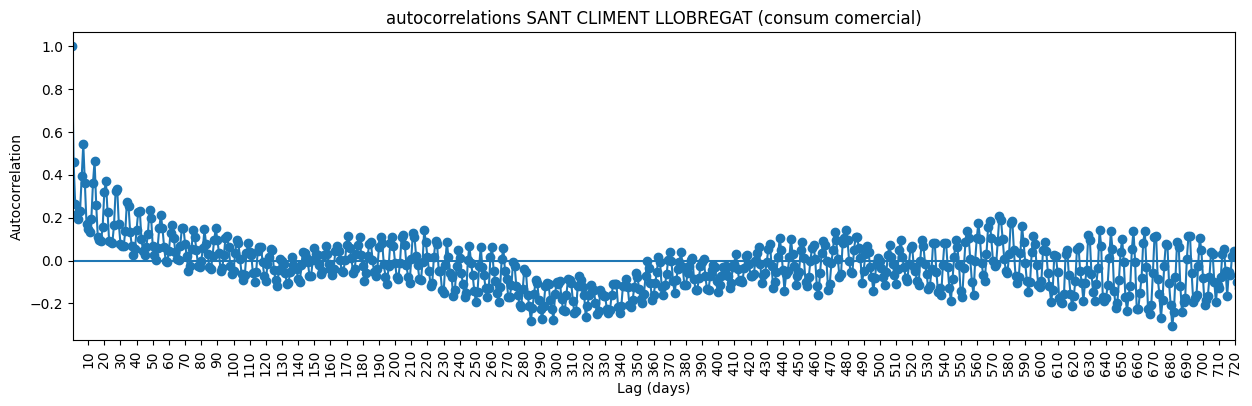

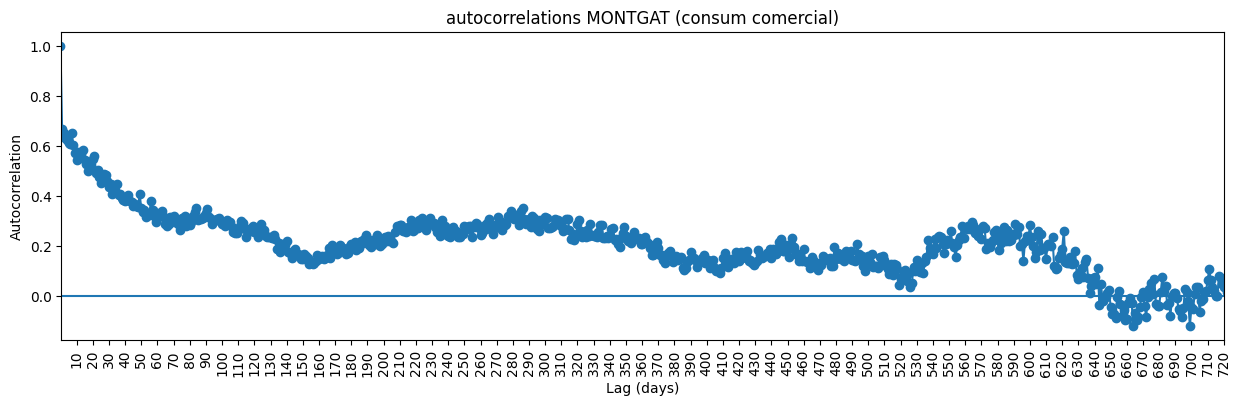

No enought data for SANTA COLOMA CERVELLO (consum comercial)
No enought data for CERDANYOLA (consum comercial)


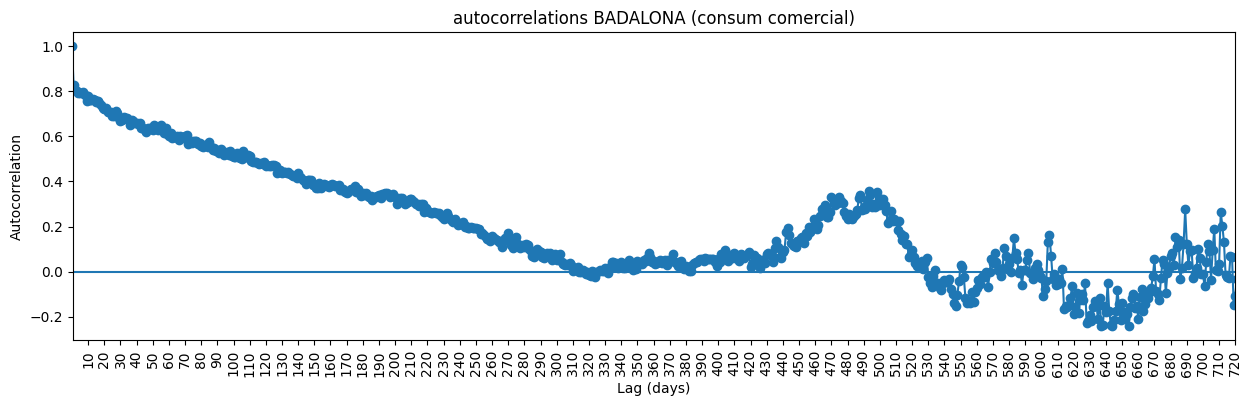

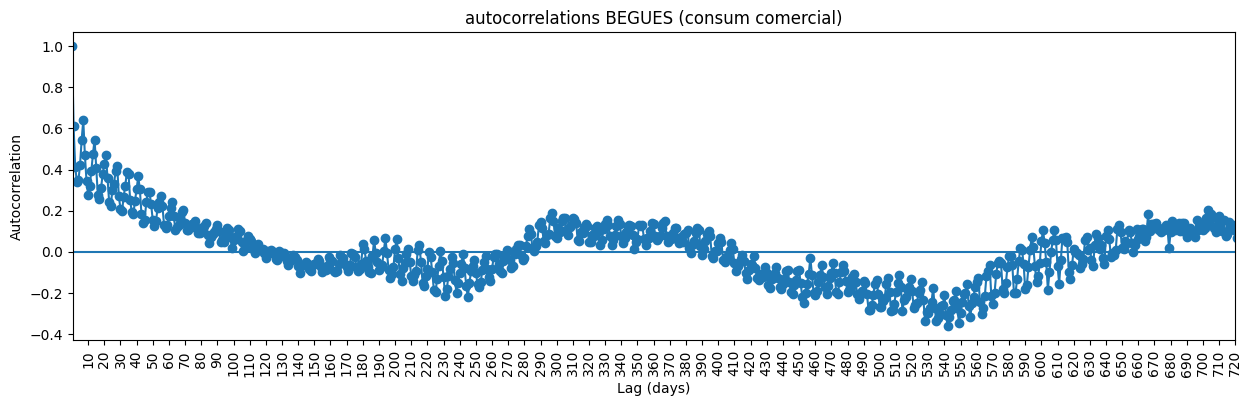

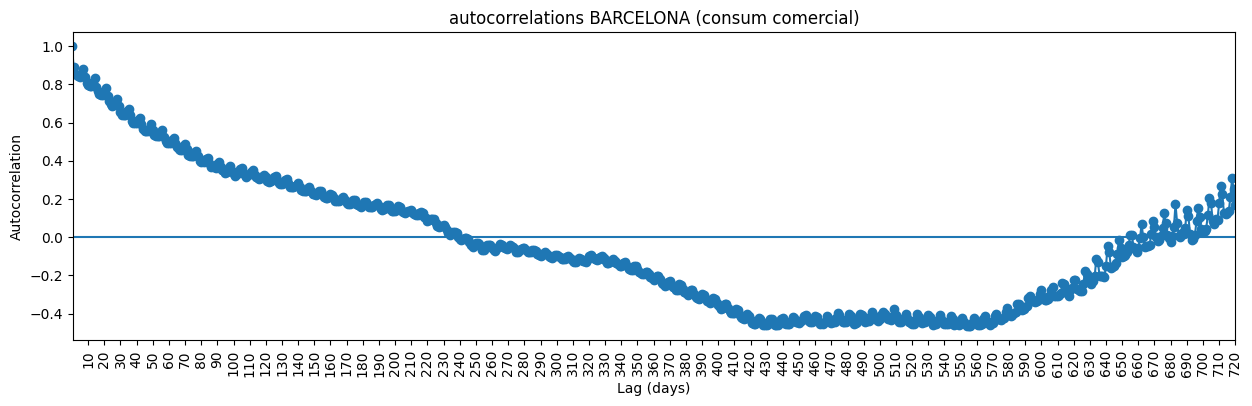

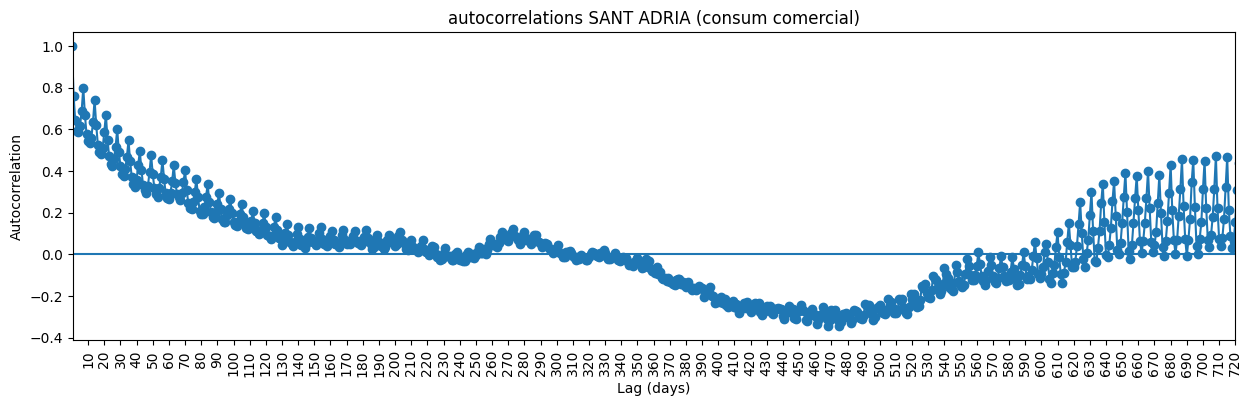

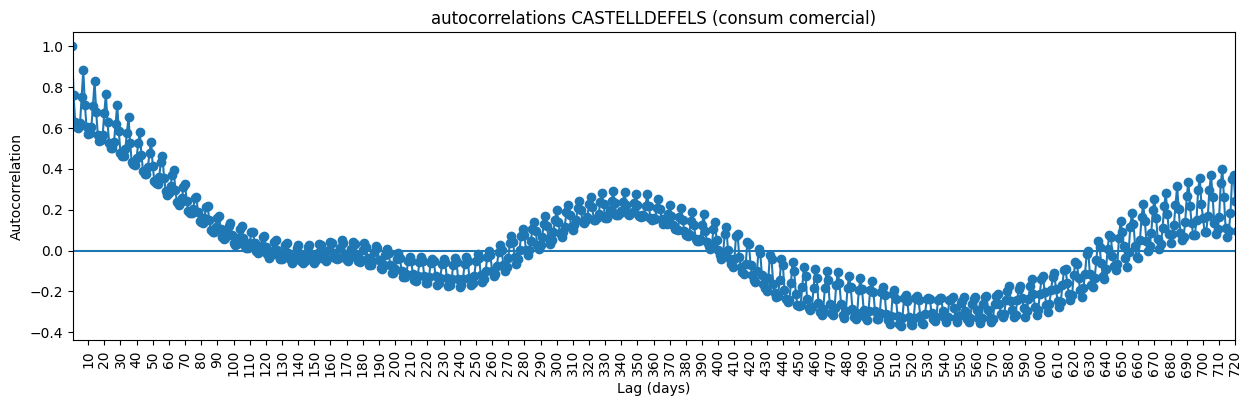

No enought data for SANT BOI (consum comercial)


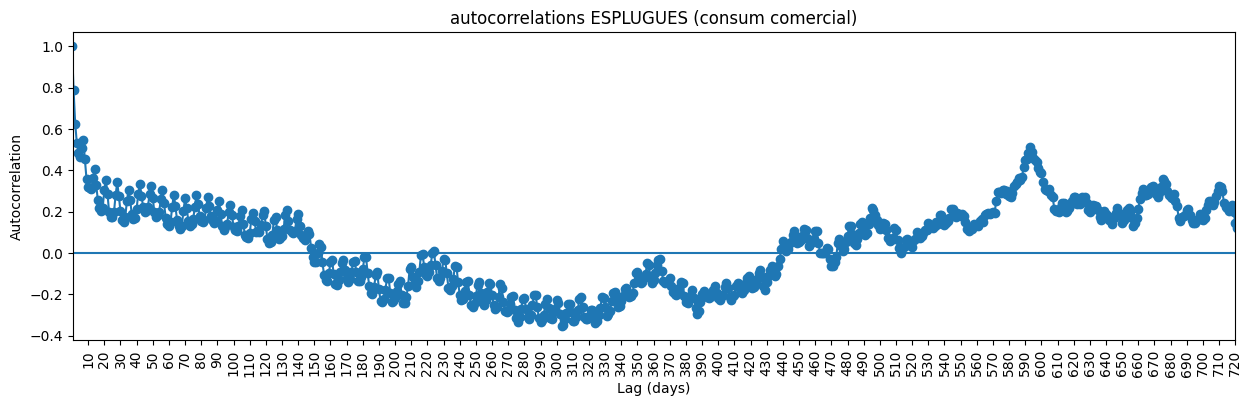

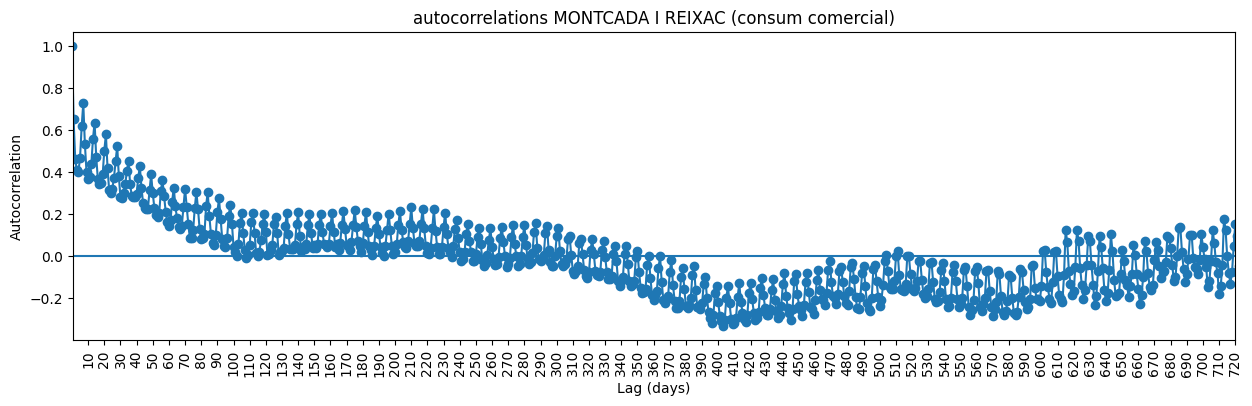

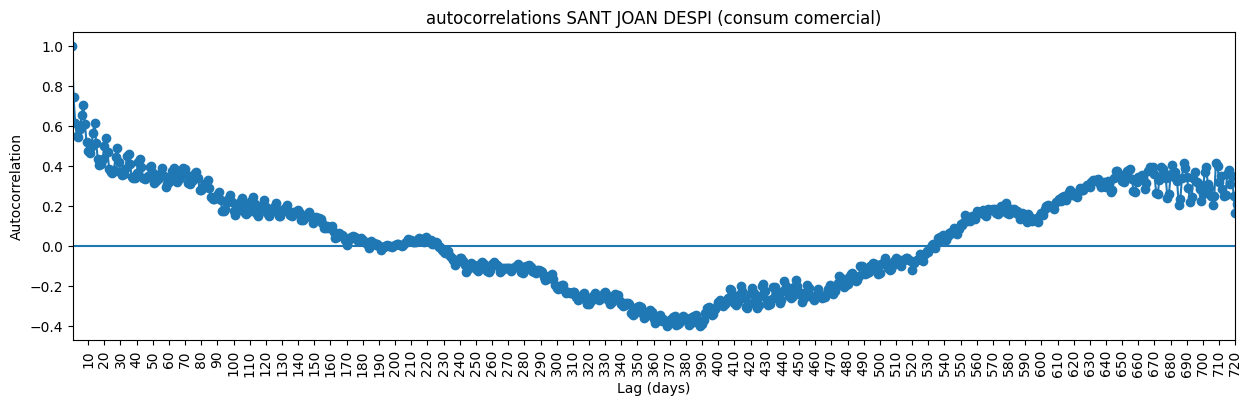

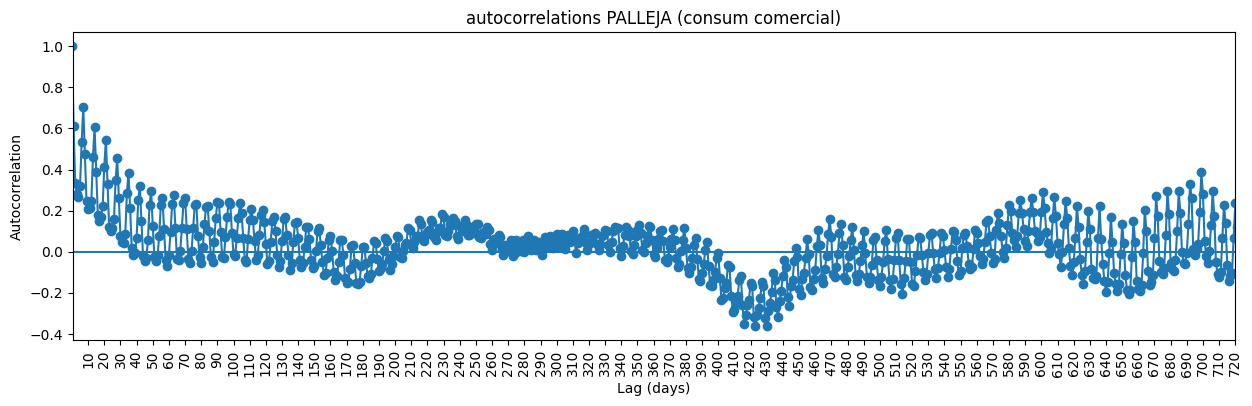

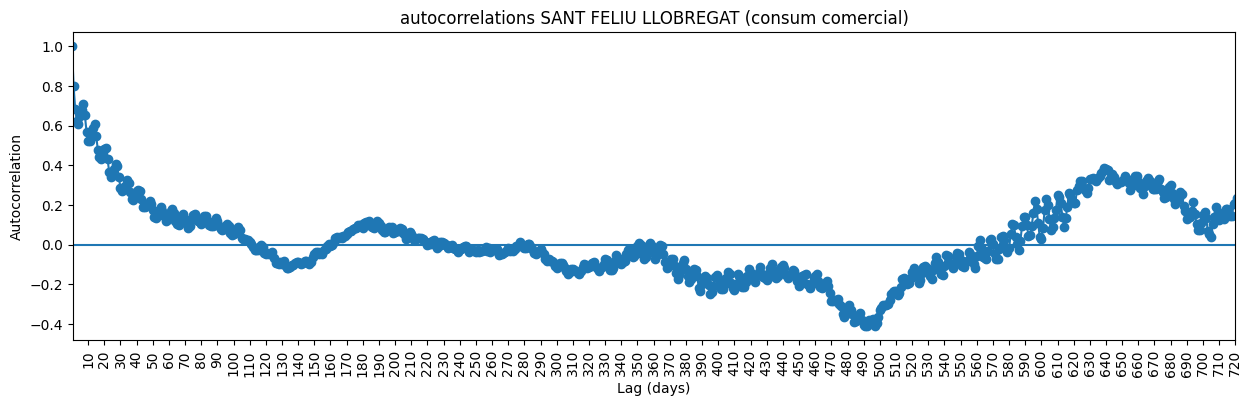

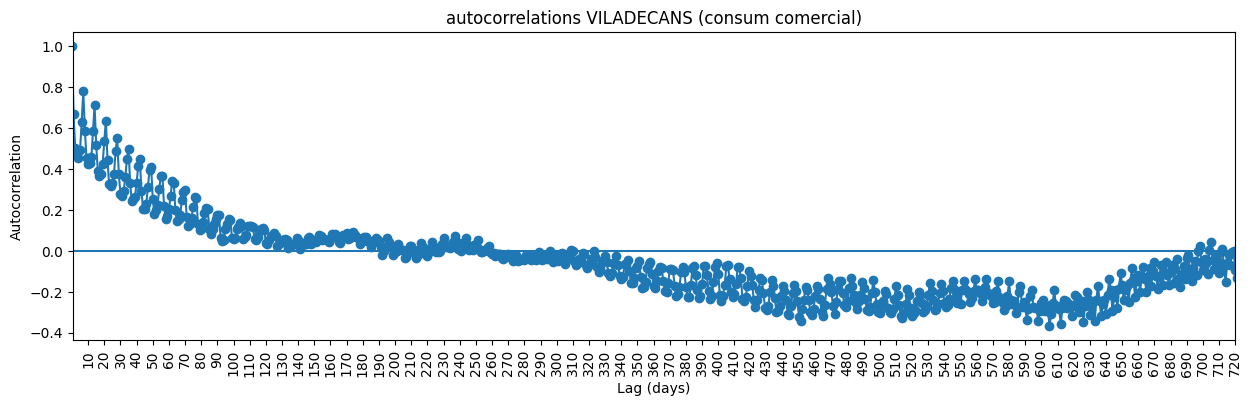

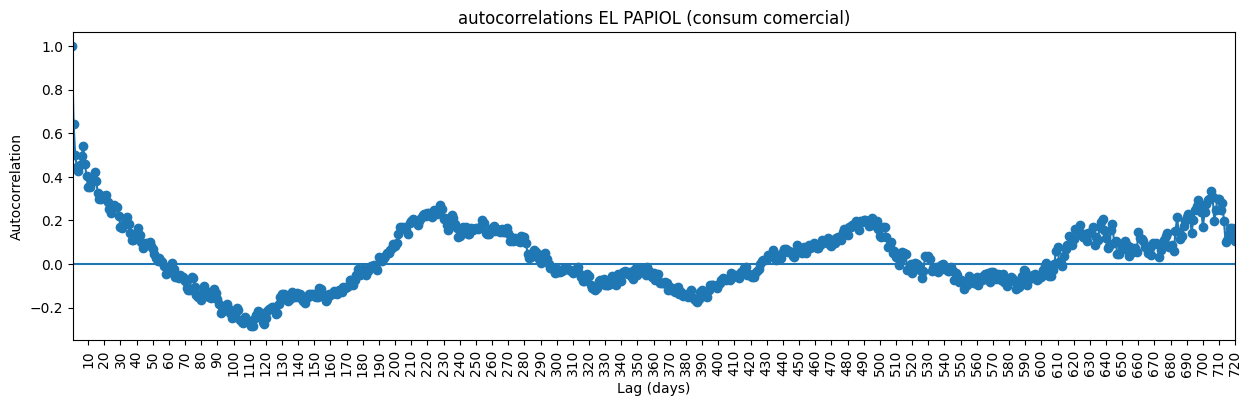

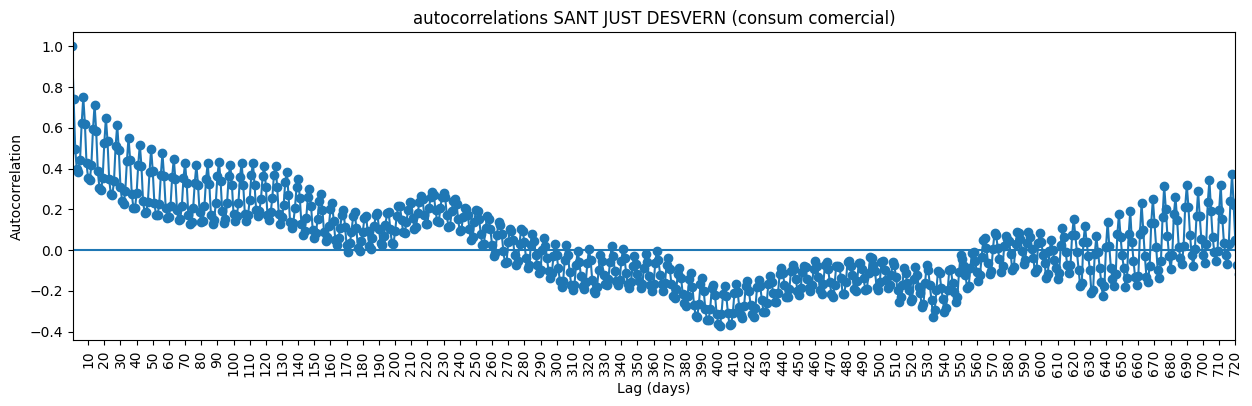

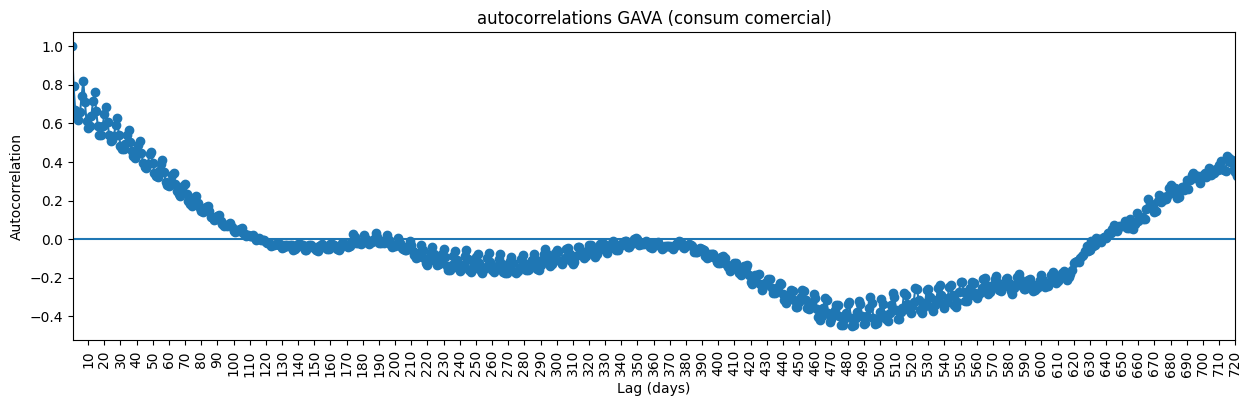

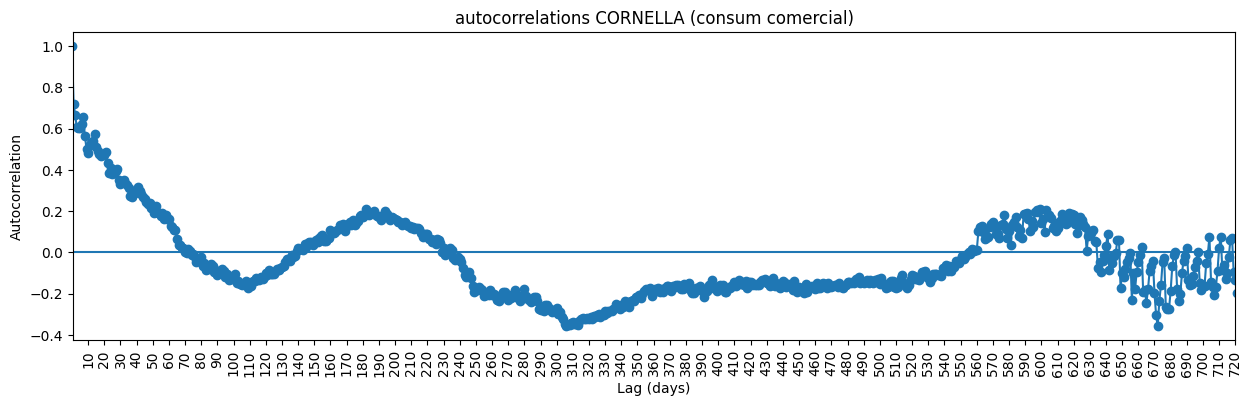

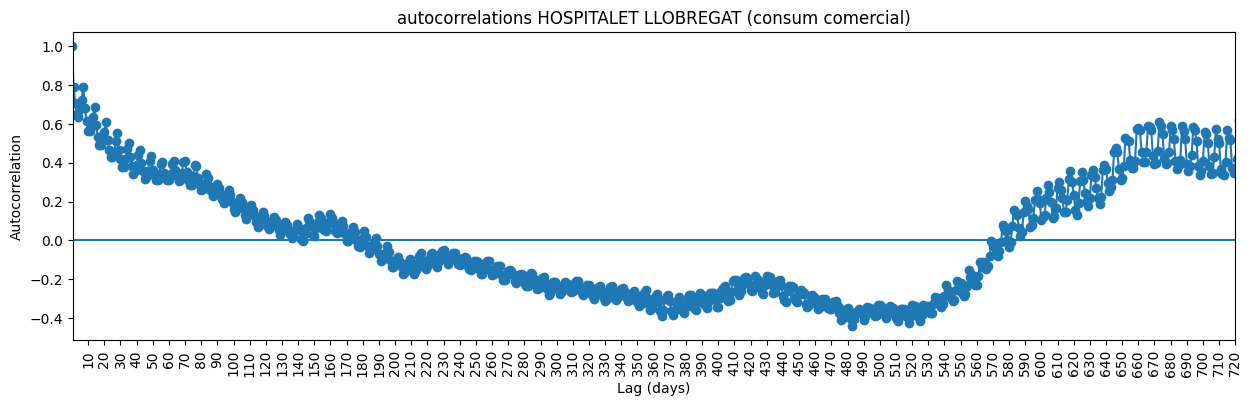

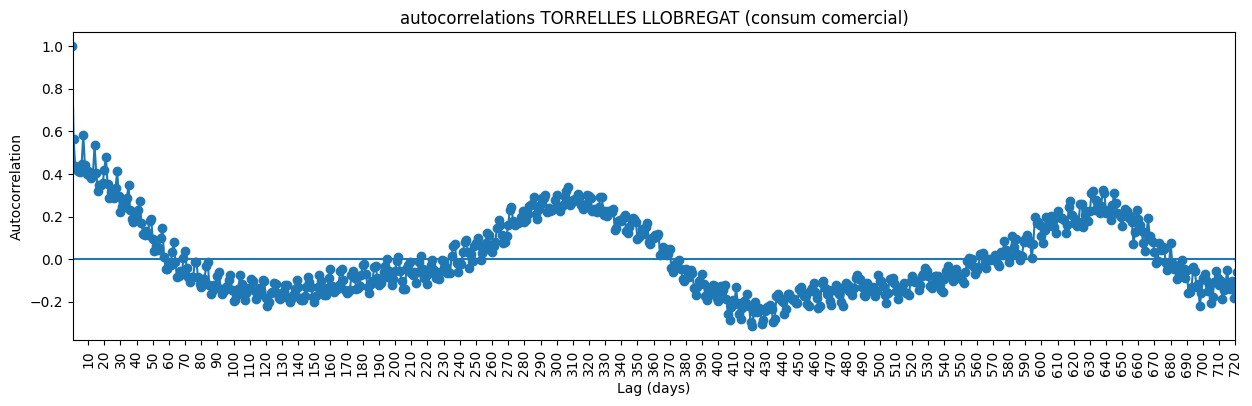

No enought data for SANTA COLOMA GRAMENET (consum comercial)


In [11]:
name2ac = dict()

for name, df in COMERCIAL_name2df.items():
    df = delete_outliers_IQR(df, "consum_per_contador")
    df = df.reset_index()
    max_periods = int(2*365)
    if len(df) < max_periods:
        print(f"No enought data for {name} (consum comercial)")
        continue
    ac = compute_autocorrelations(df["consum_per_contador"], max_periods)
    plot_auto_correlations(ac, title=f"autocorrelations {name} (consum comercial)")

Veient aquestes gràfiques, hem decidit utilitxar gaps de 1 i de 7 dies per el consum comercial.

In [12]:
lags_COMERCIAL = [1, 7]
lagged_COMERCIAL_name2df = dict()
for name, df in COMERCIAL_name2df.items():
    lagged_df = df.copy()
    for lag in lags_COMERCIAL:
        lagged_df[f"consum_per_contador_{lag}"] = lagged_df["consum_per_contador"].shift(lag)
    lagged_COMERCIAL_name2df[name] = lagged_df

### Domestic

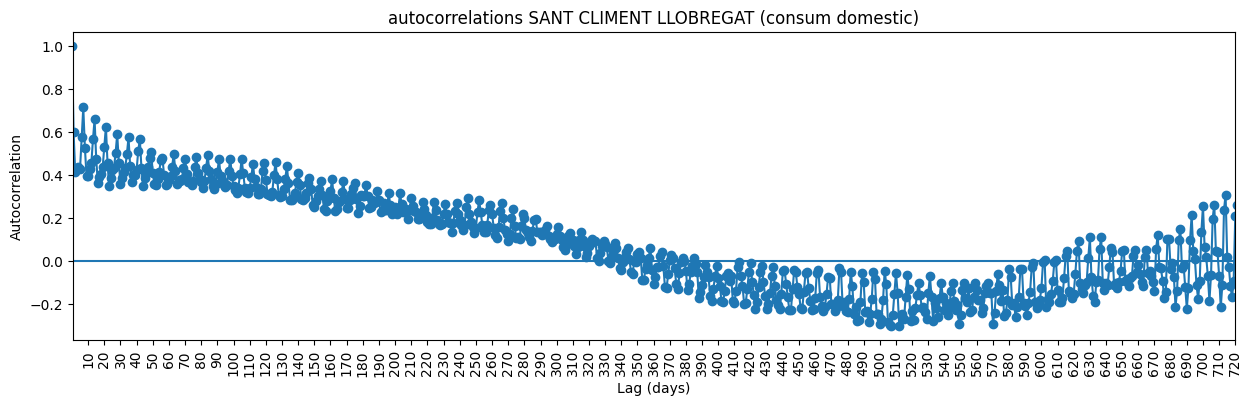

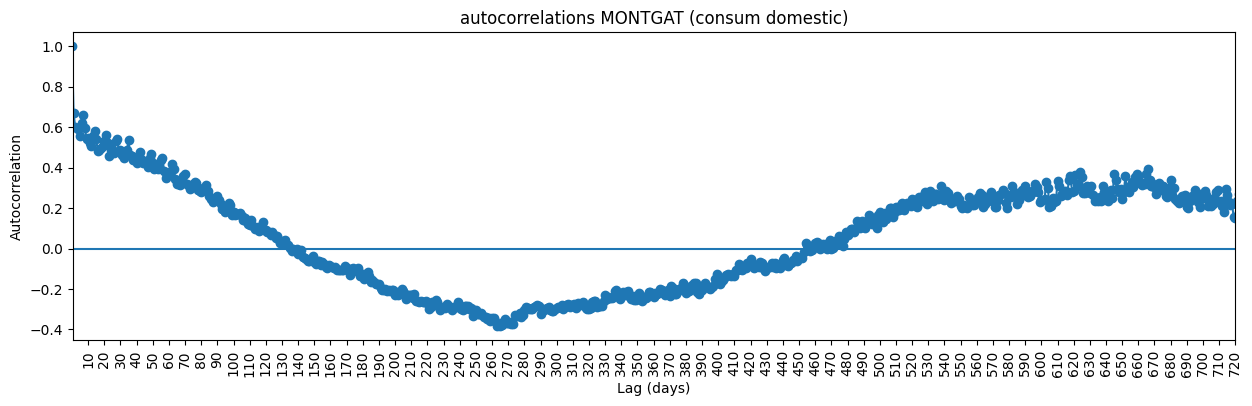

No enought data for SANTA COLOMA CERVELLO (consum domestic)


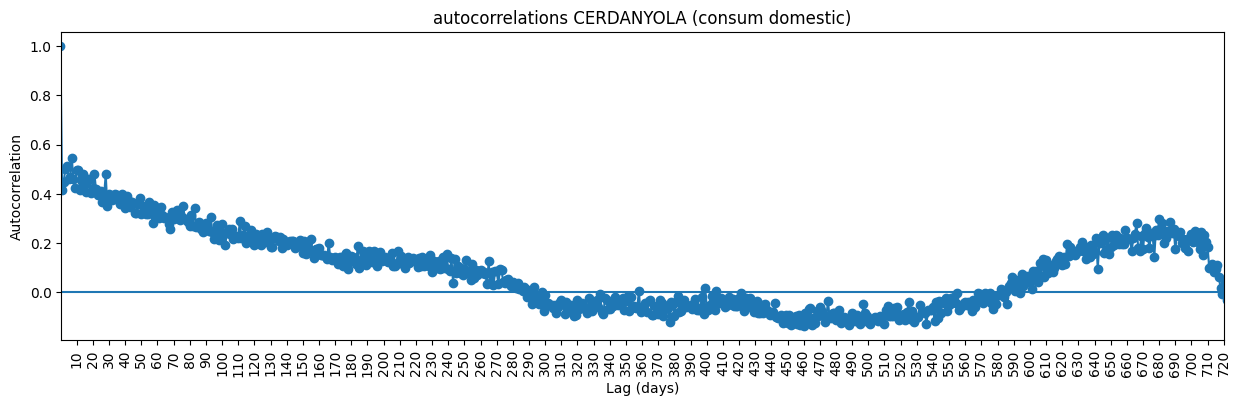

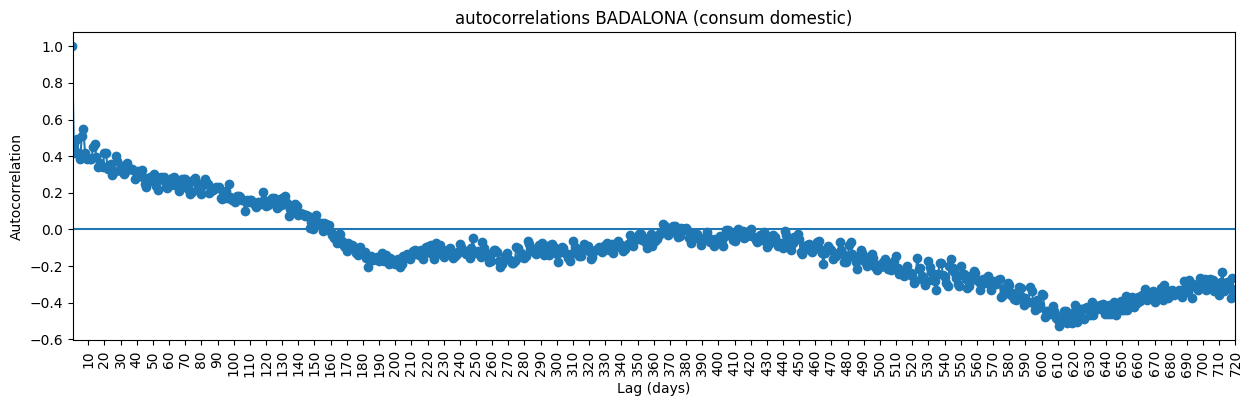

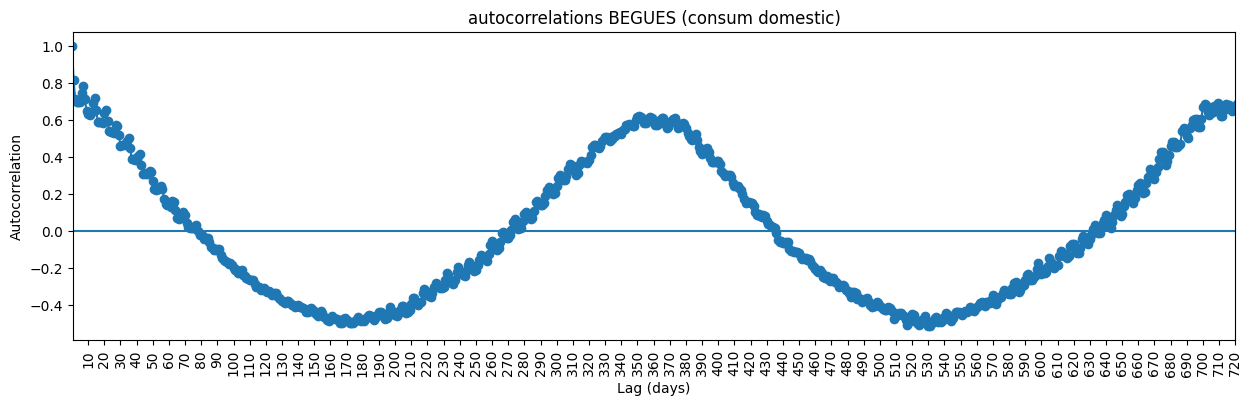

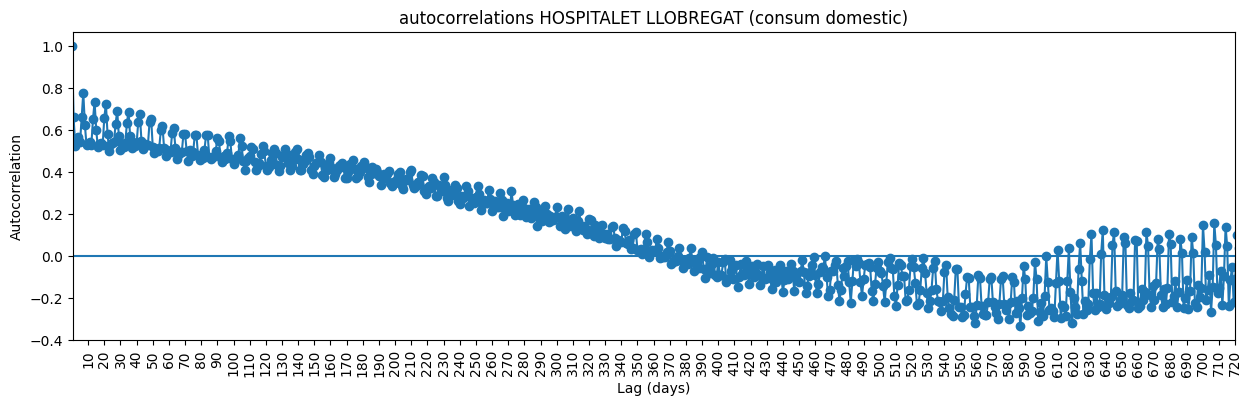

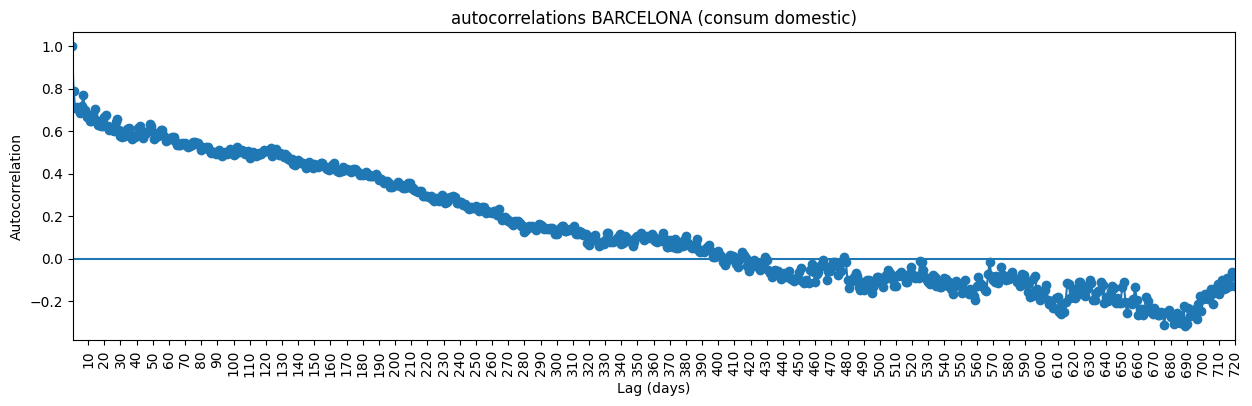

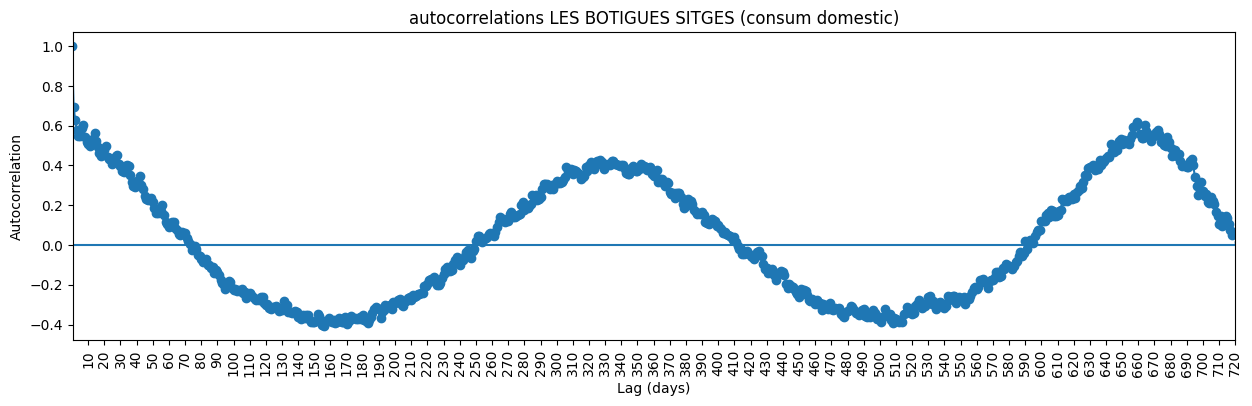

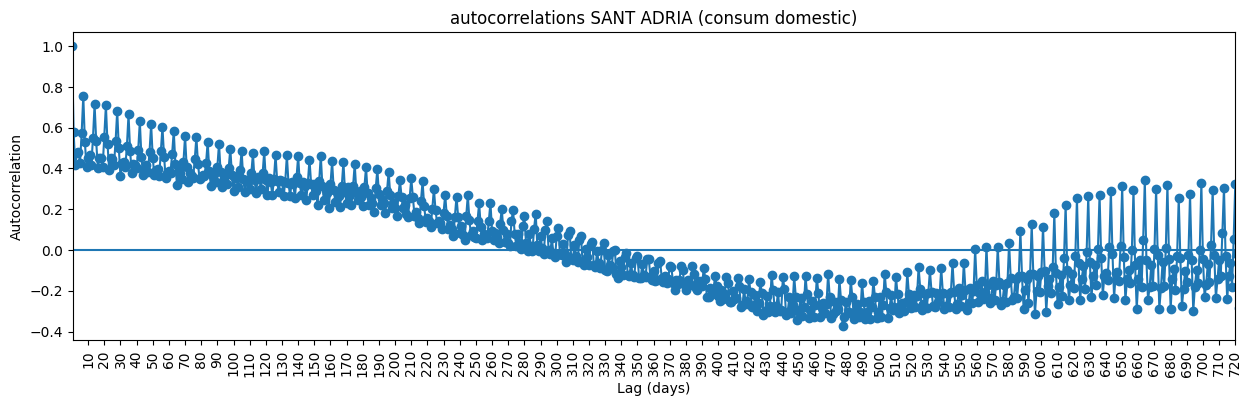

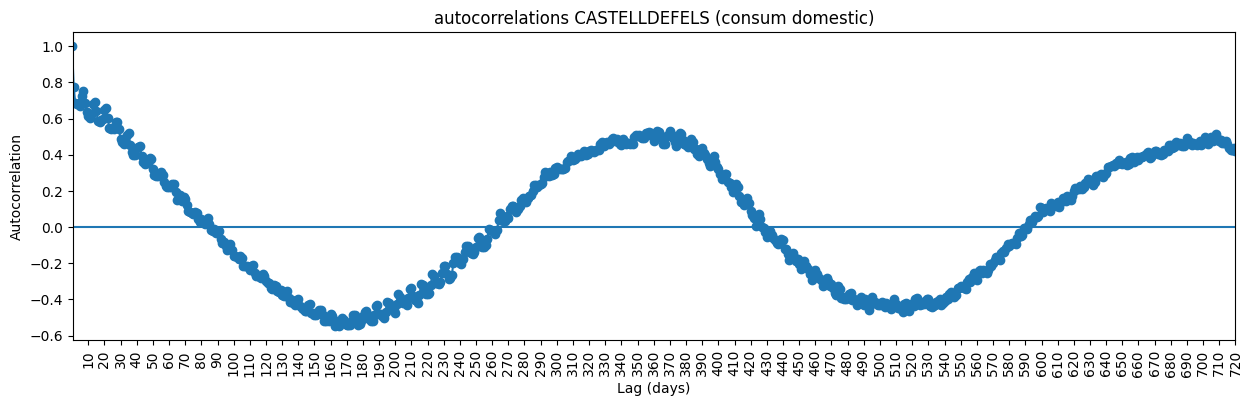

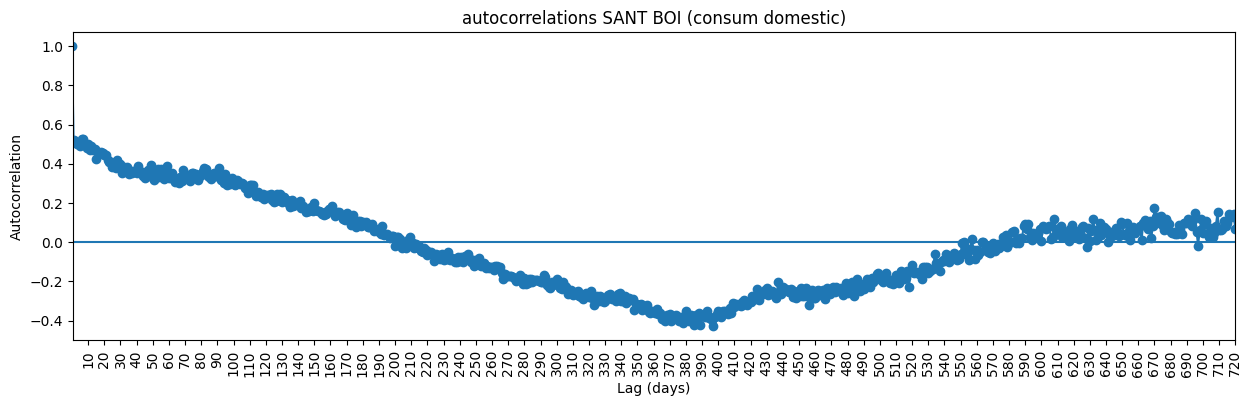

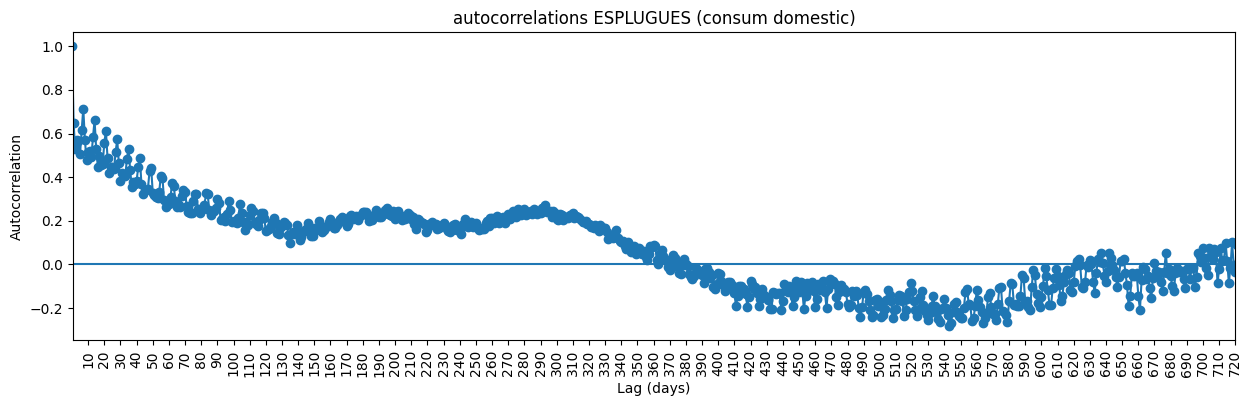

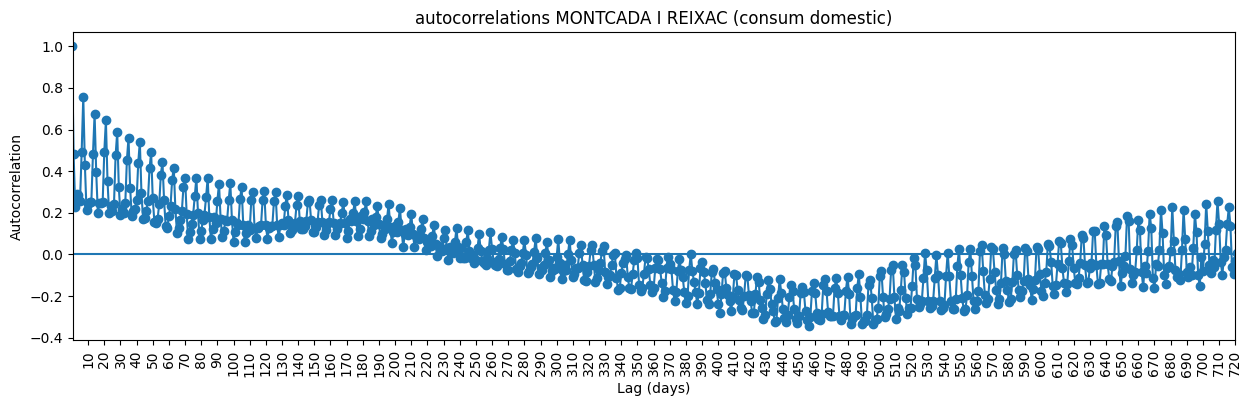

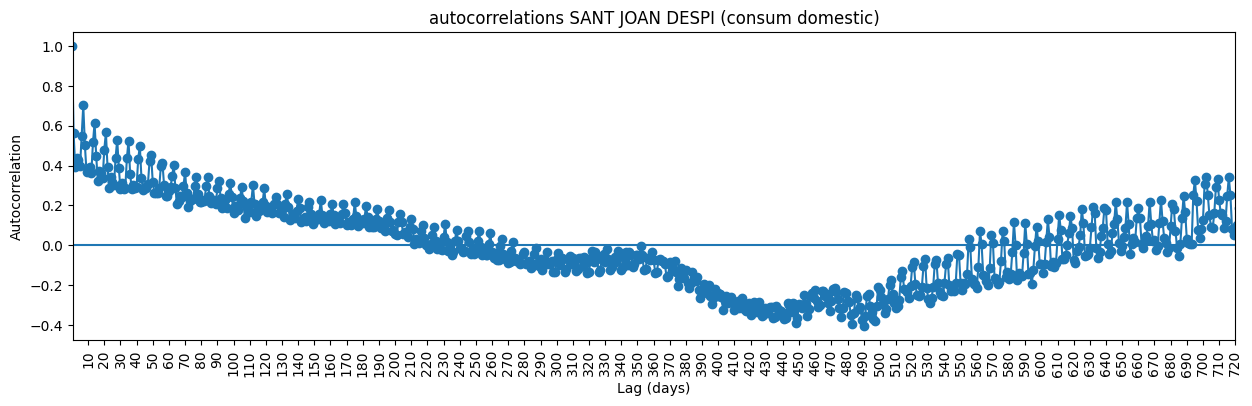

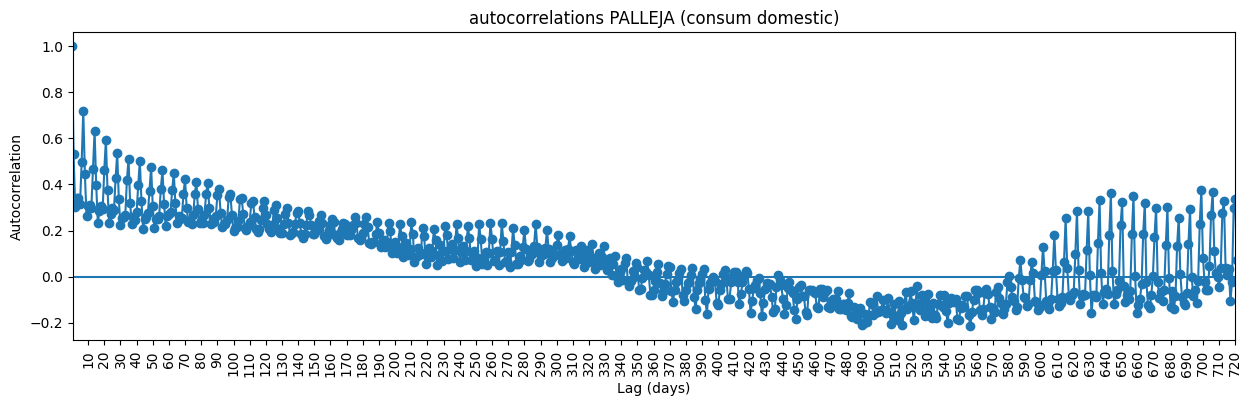

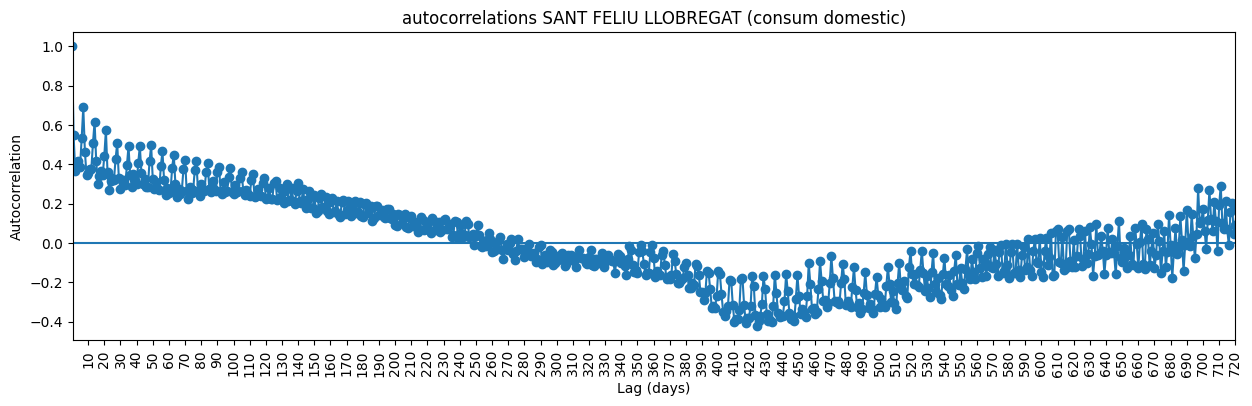

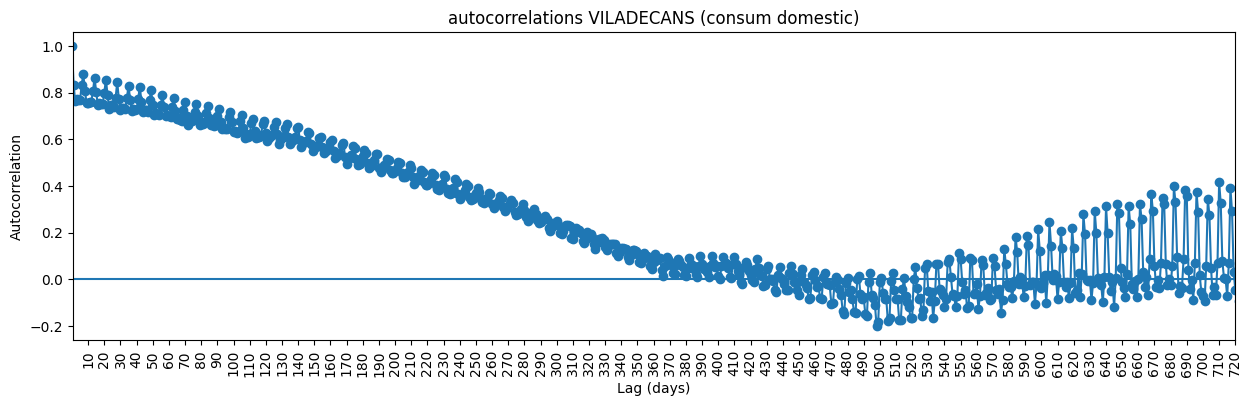

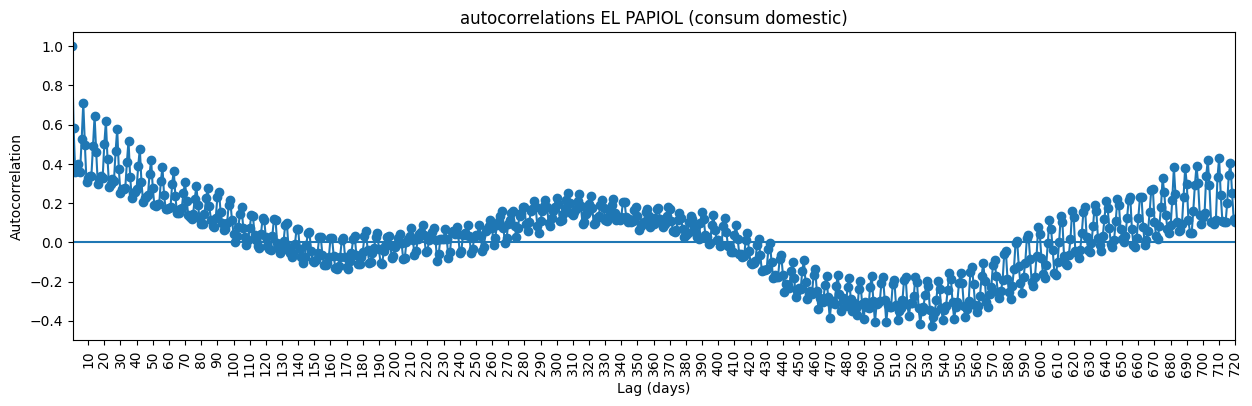

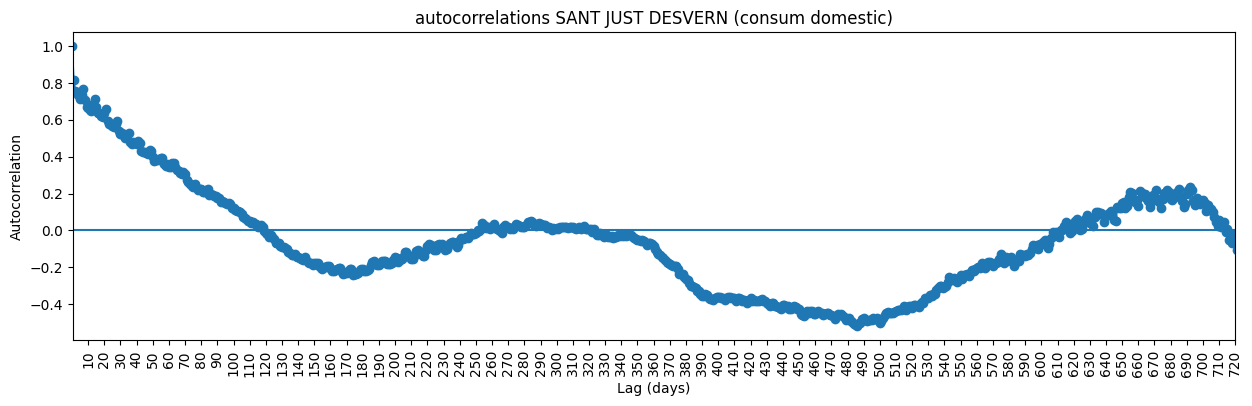

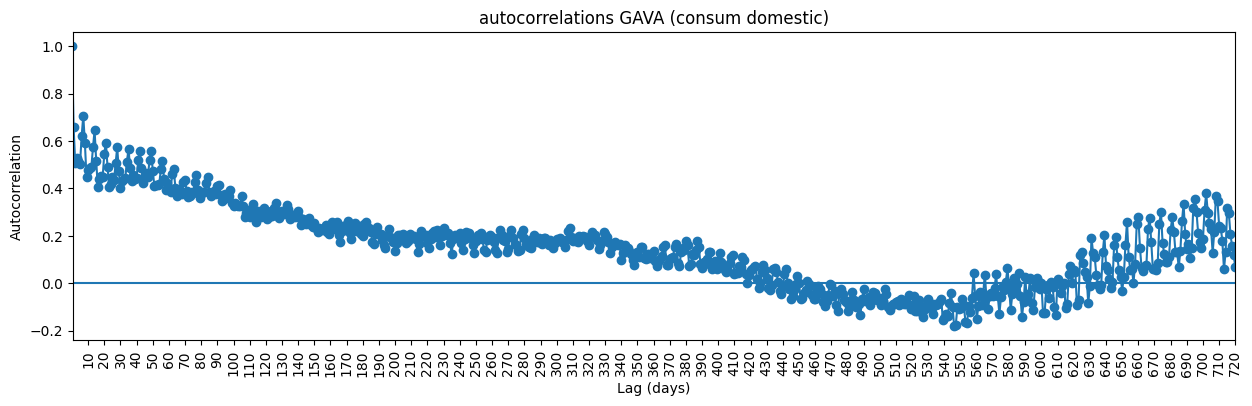

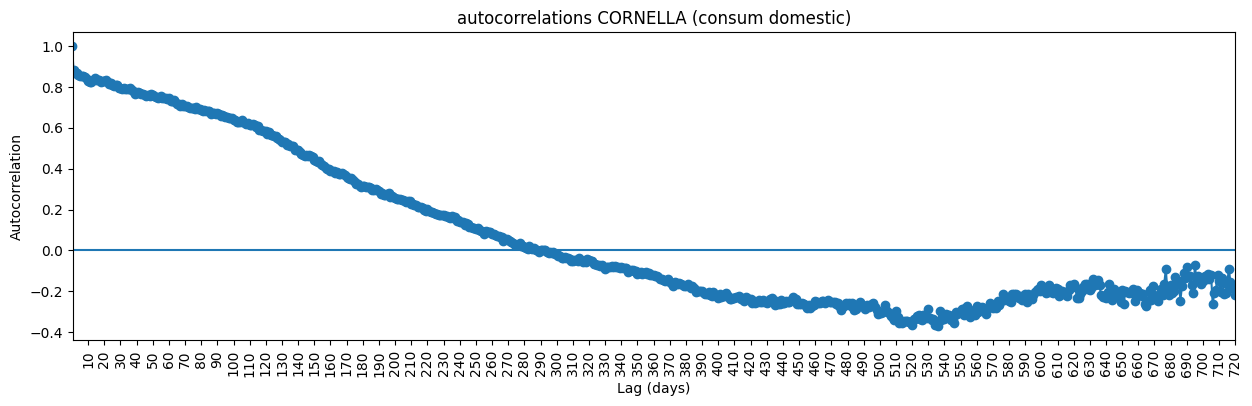

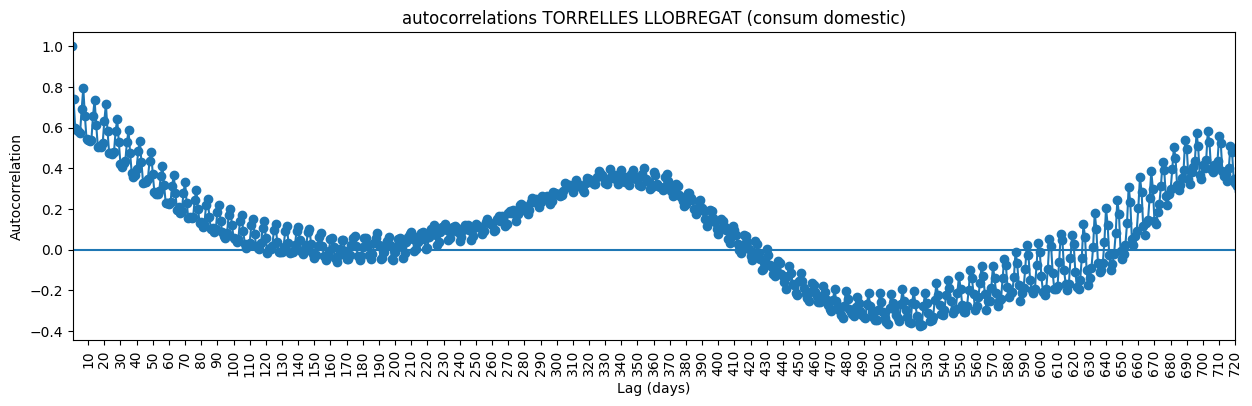

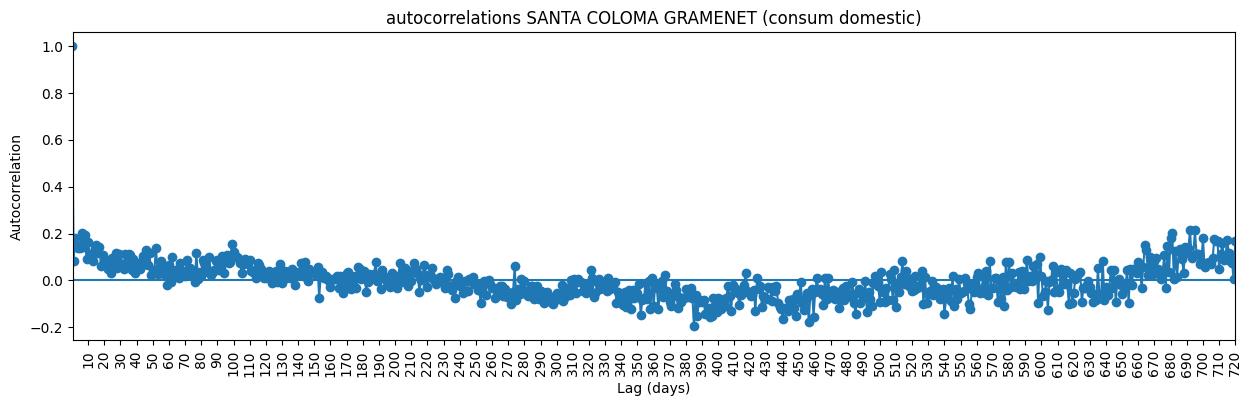

In [13]:
name2ac = dict()

for name, df in DOMESTIC_name2df.items():
    df = delete_outliers_IQR(df, "consum_per_contador")
    df = df.reset_index()
    max_periods = int(2*365)
    if len(df) < max_periods:
        print(f"No enought data for {name} (consum domestic)")
        continue
    ac = compute_autocorrelations(df["consum_per_contador"], max_periods)
    plot_auto_correlations(ac, title=f"autocorrelations {name} (consum domestic)")

Veient aquestes gràfiques, hem decidit utilitxar gaps de 1 i de 7 dies per el consum comercial.

In [14]:
lags_DOMESTIC = [1, 7]
lagged_DOMESTIC_name2df = dict()
for name, df in DOMESTIC_name2df.items():
    lagged_df = df.copy()
    for lag in lags_DOMESTIC:
        lagged_df[f"consum_per_contador_{lag}"] = lagged_df["consum_per_contador"].shift(lag)
    lagged_DOMESTIC_name2df[name] = lagged_df

### Industrial

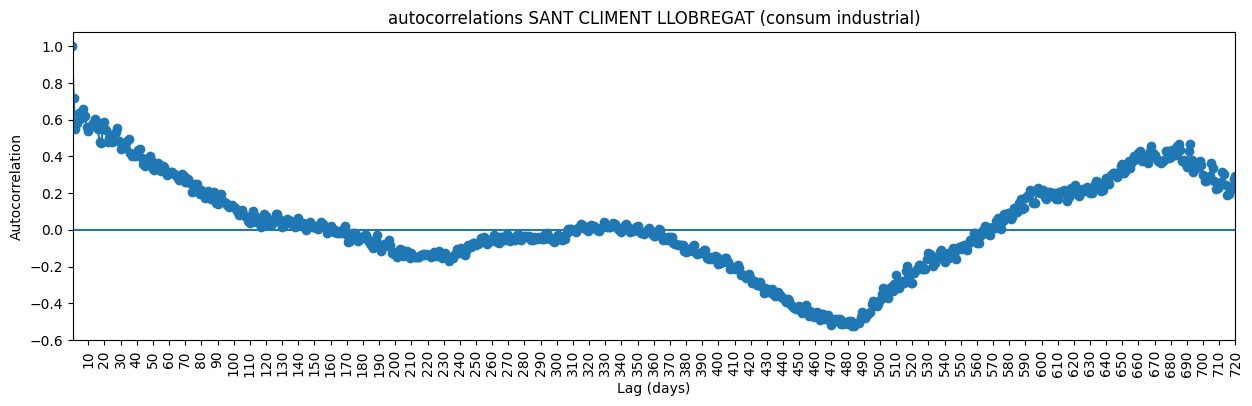

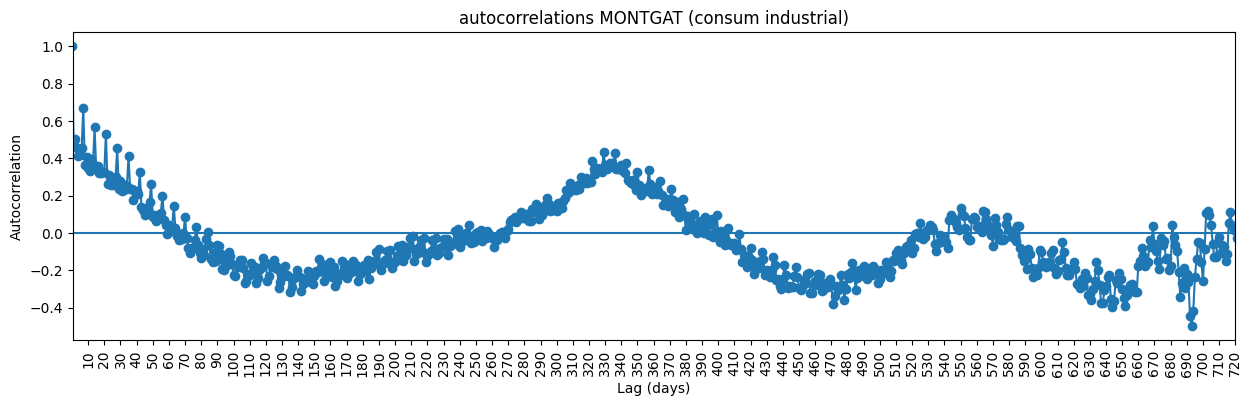

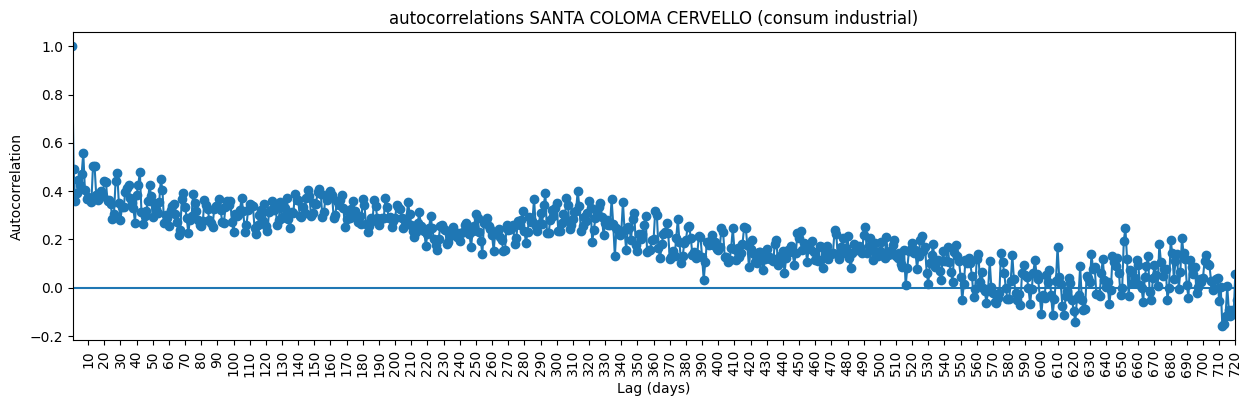

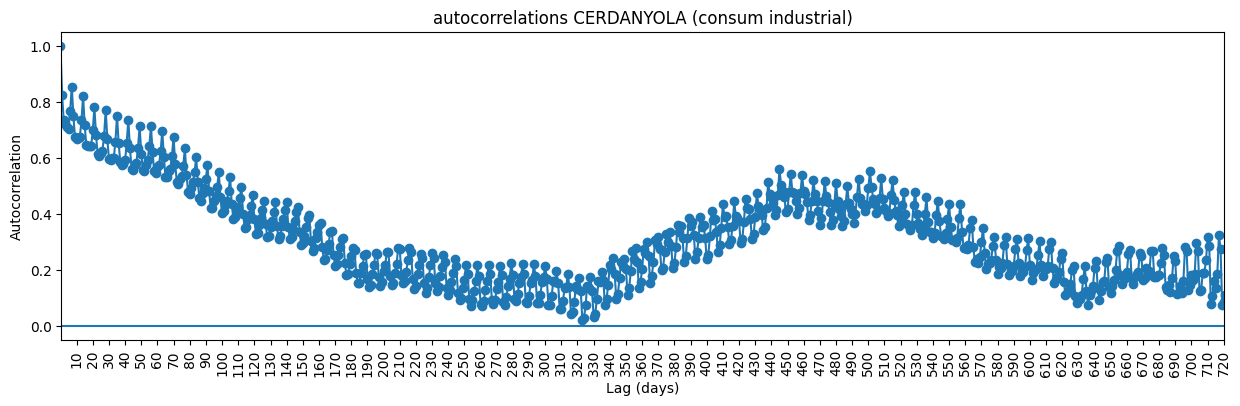

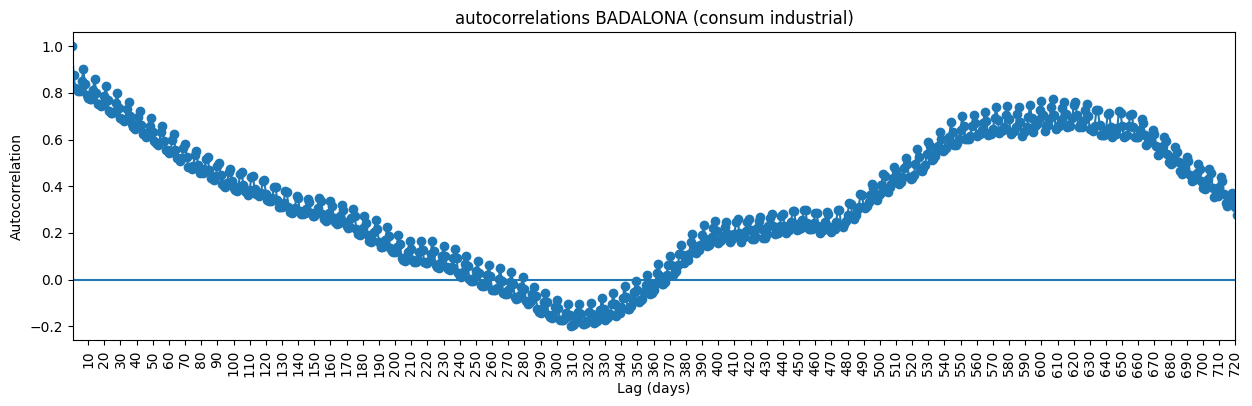

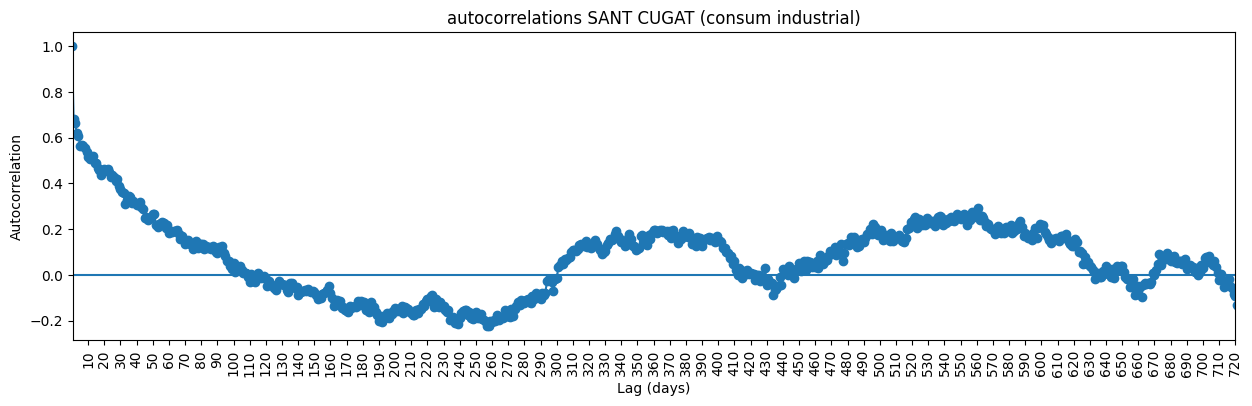

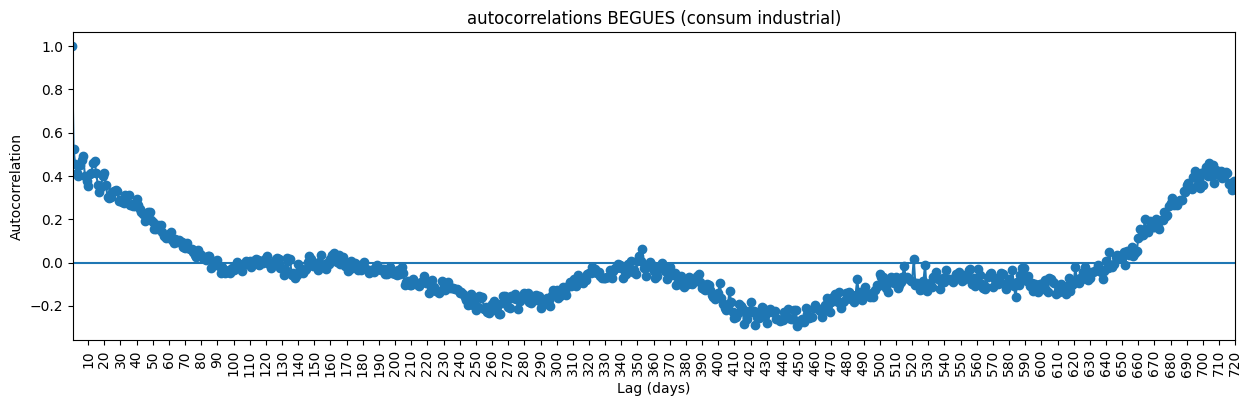

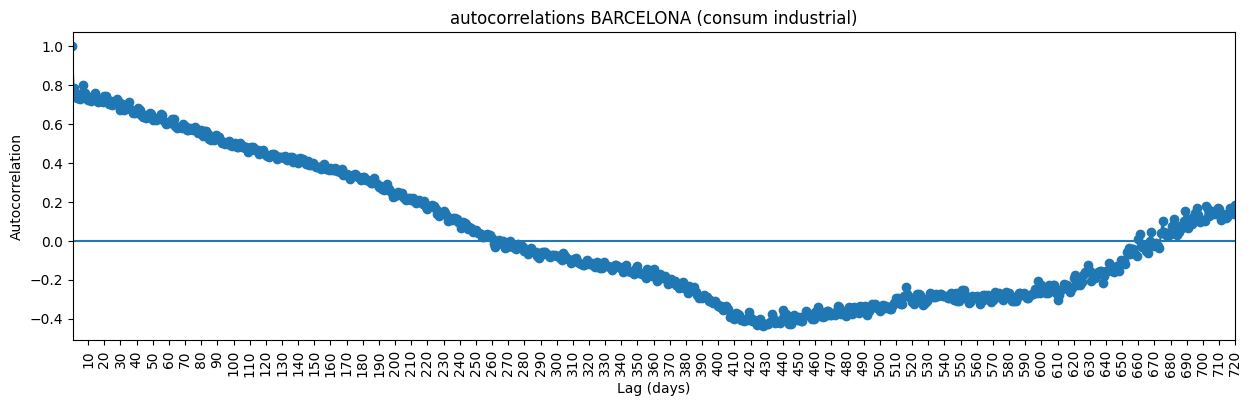

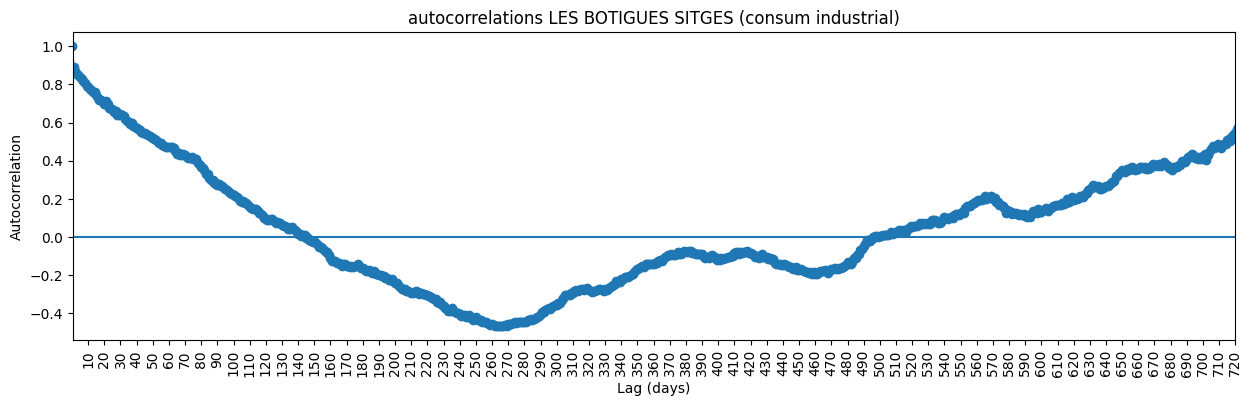

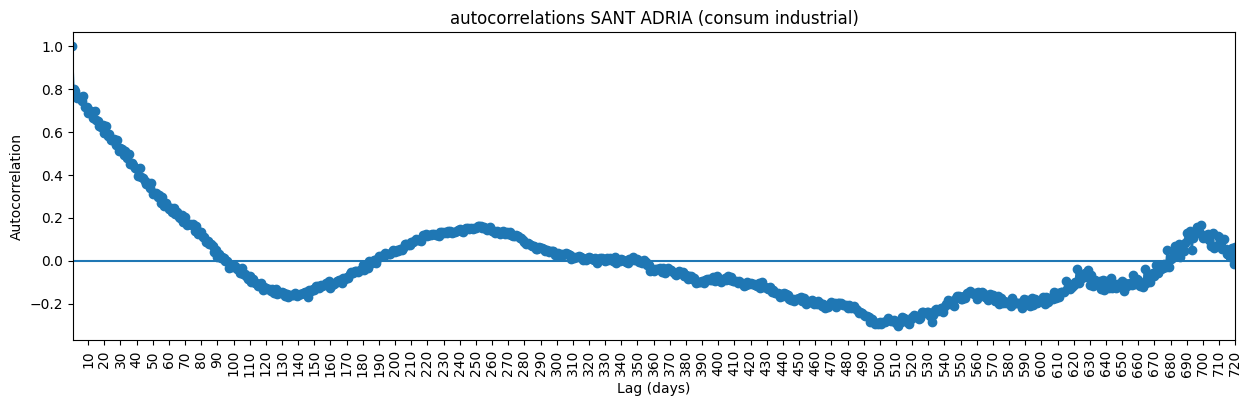

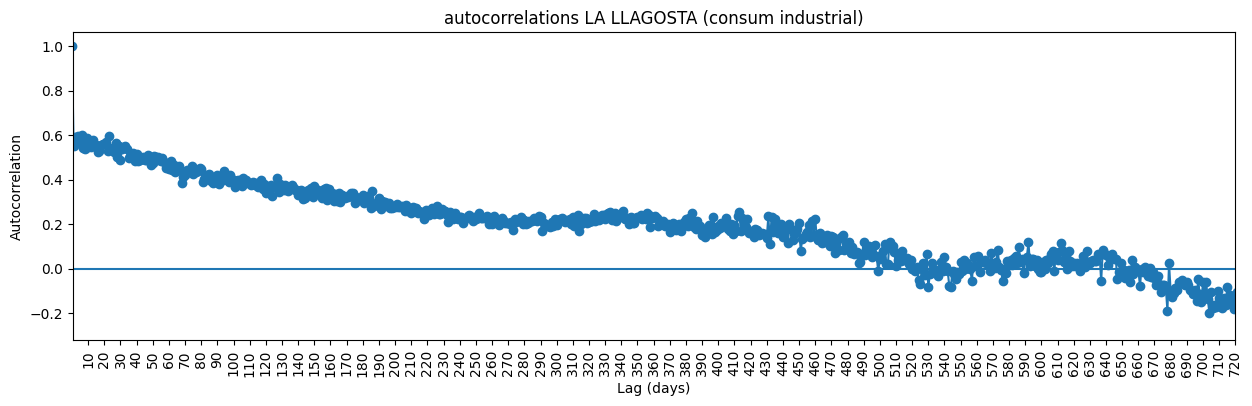

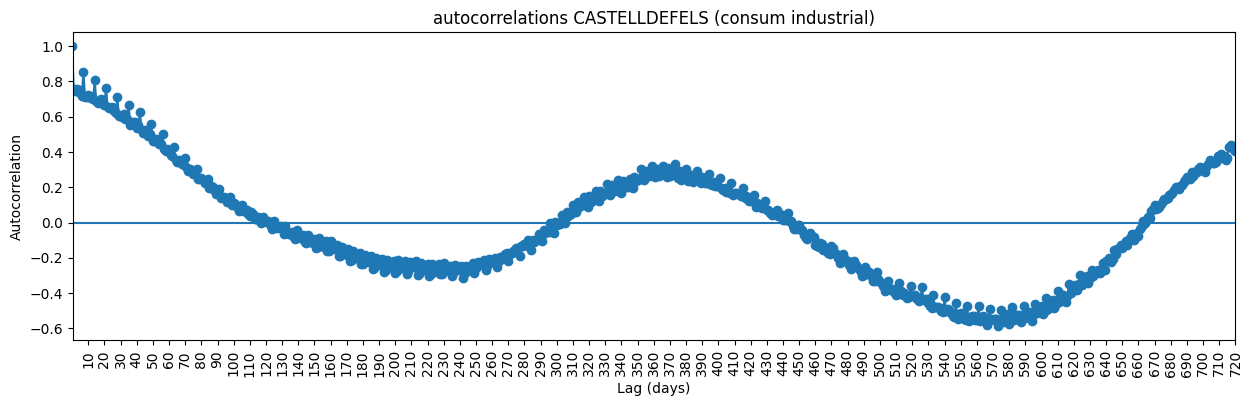

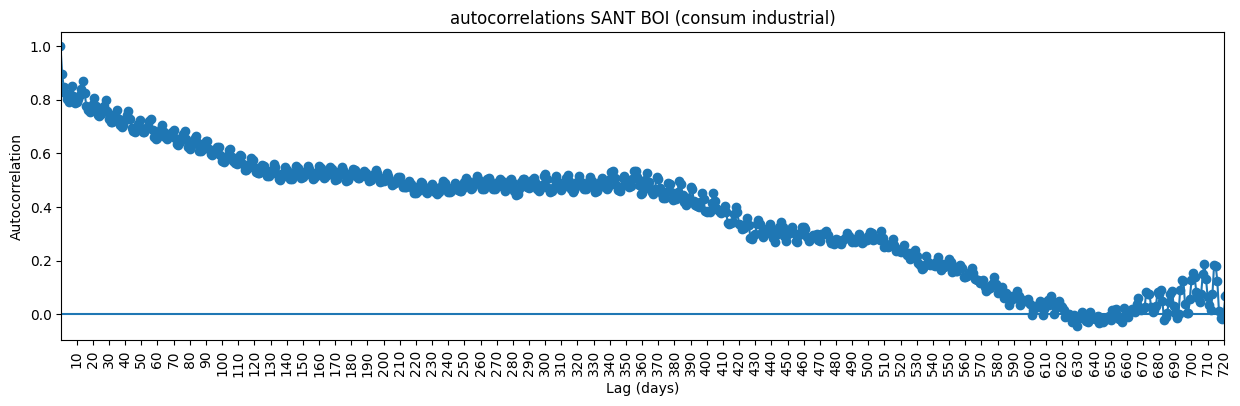

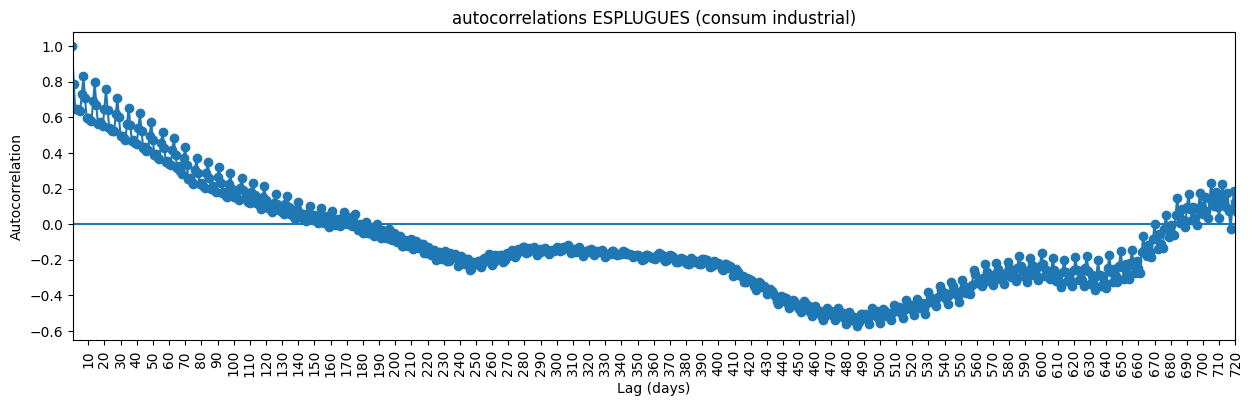

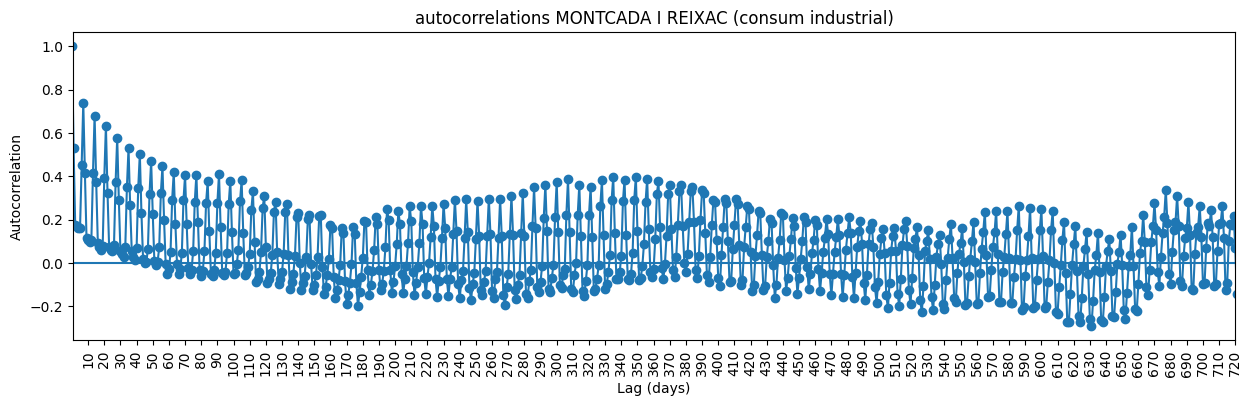

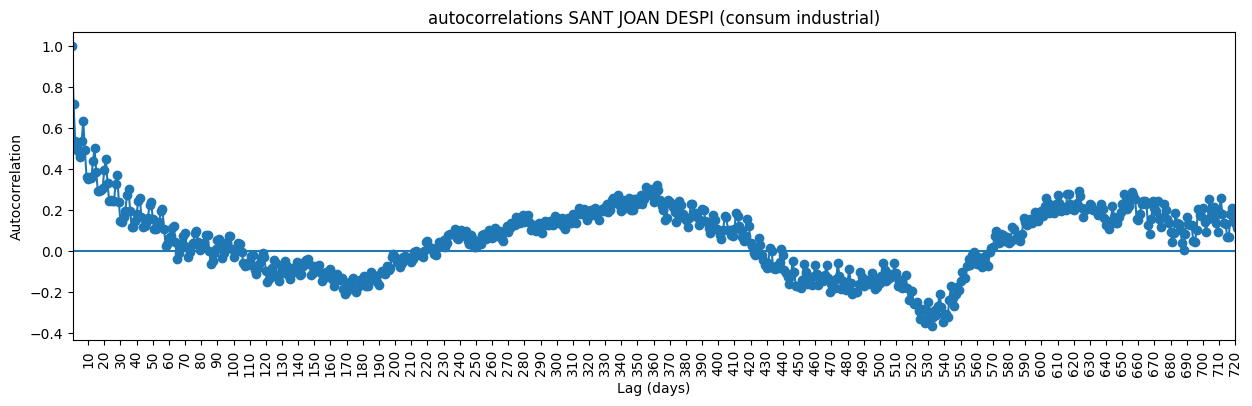

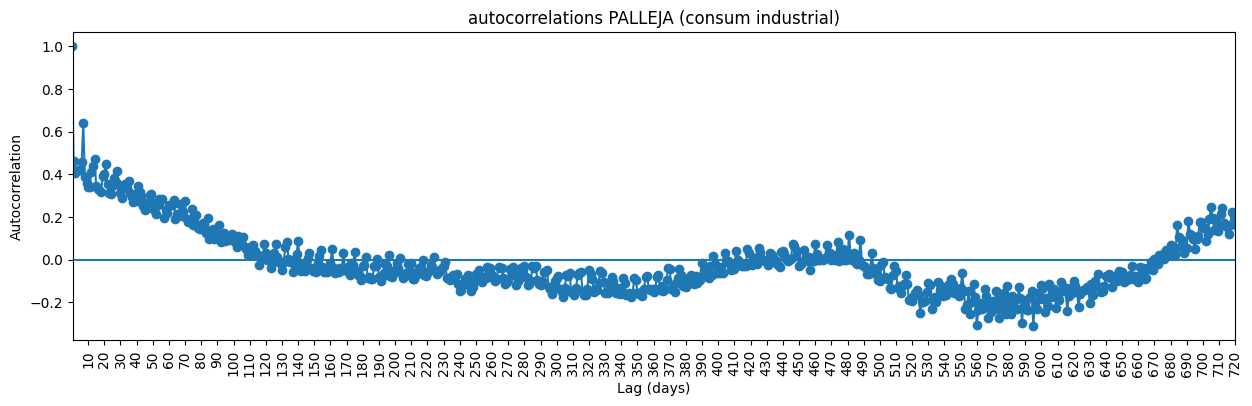

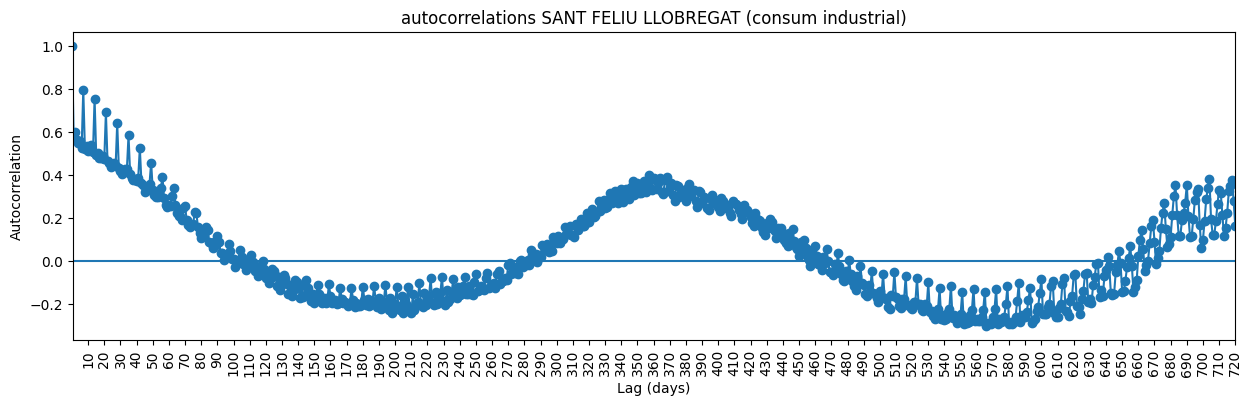

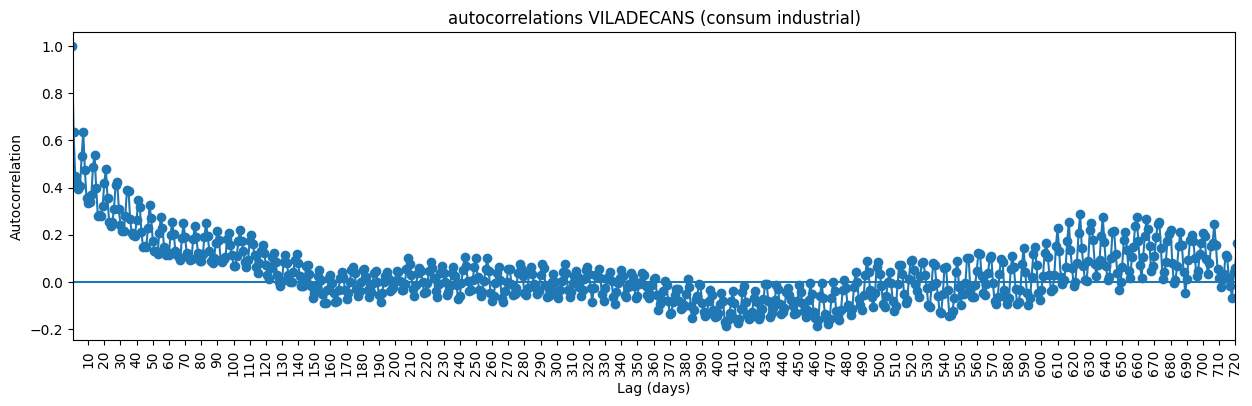

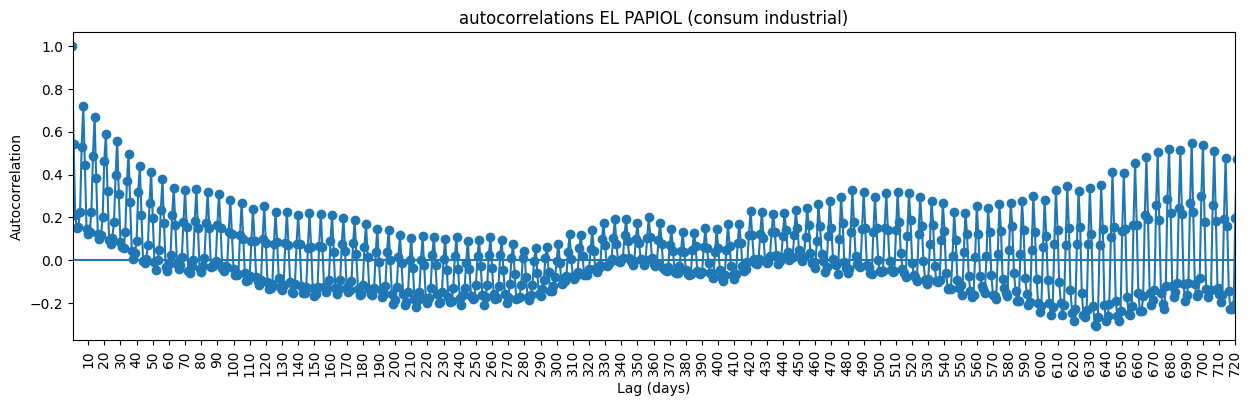

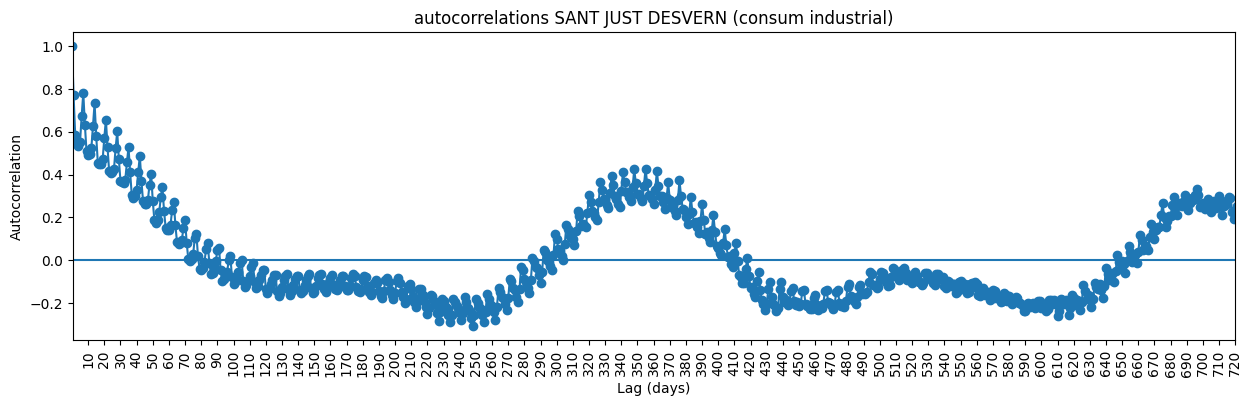

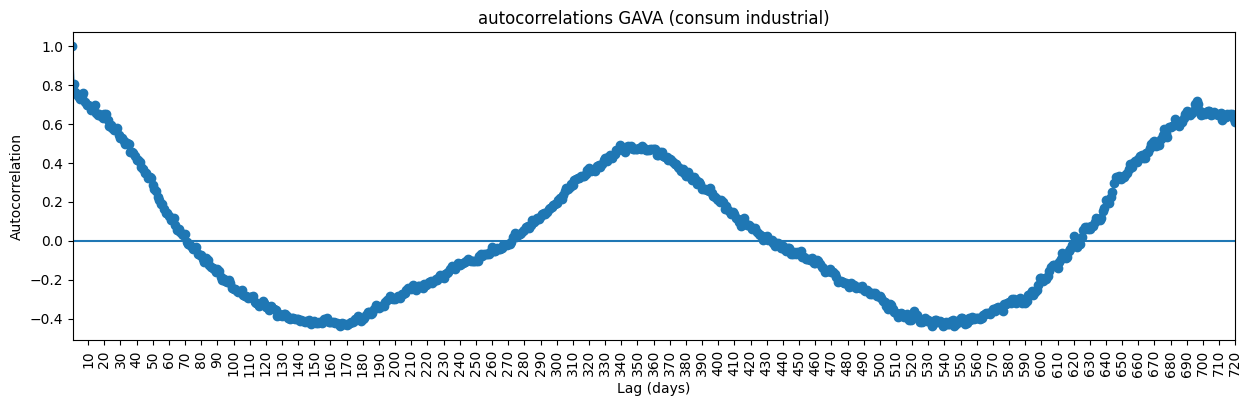

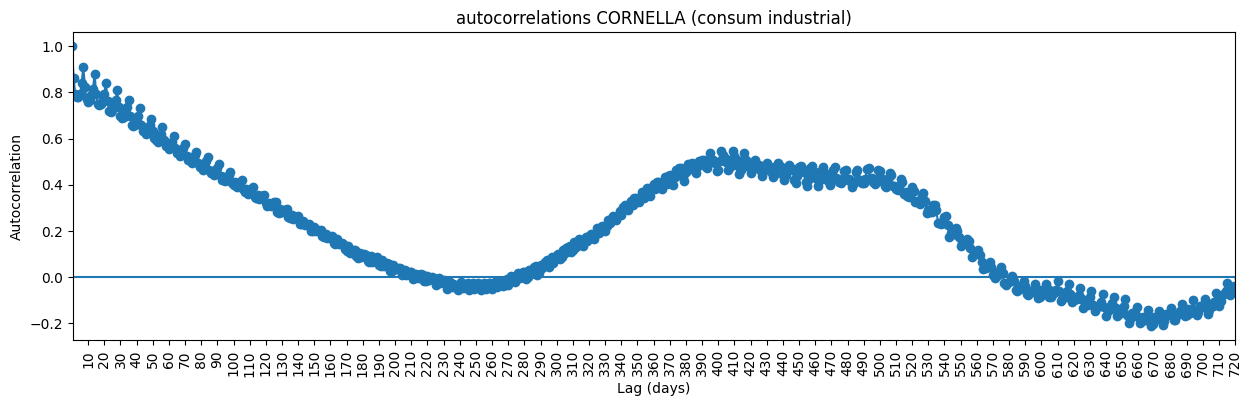

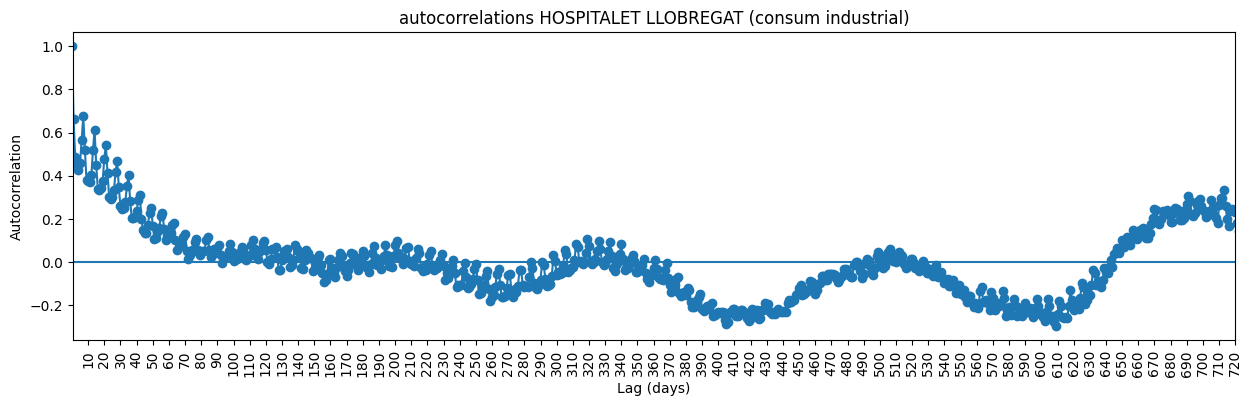

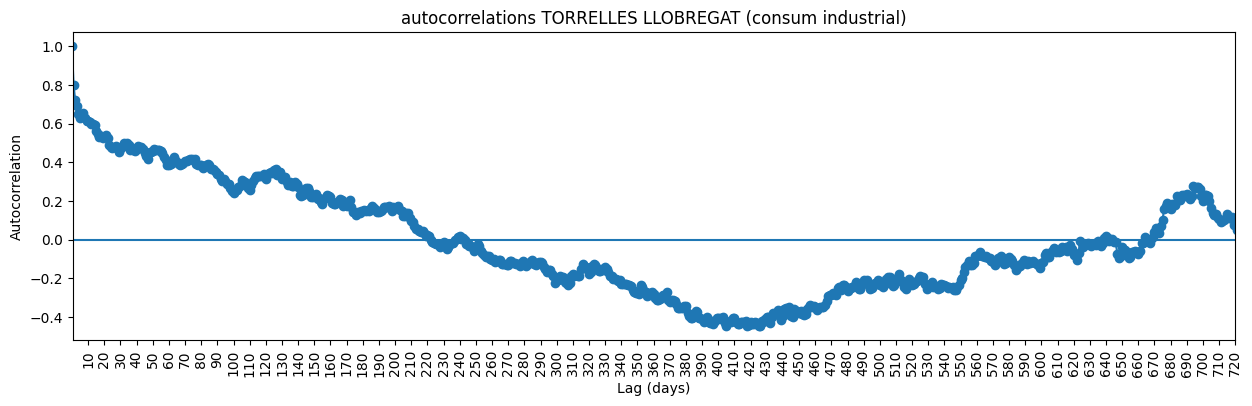

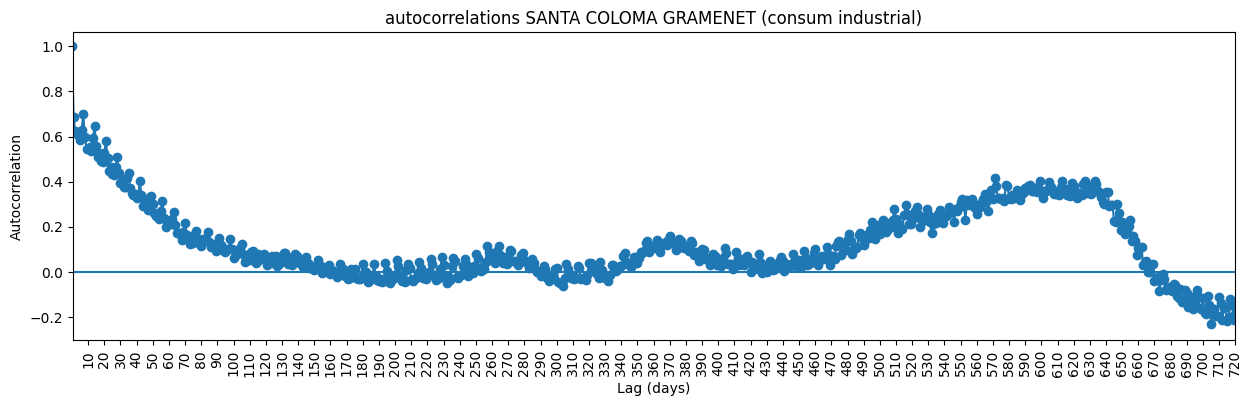

In [15]:
name2ac = dict()

for name, df in INDUSTRIAL_name2df.items():
    df = delete_outliers_IQR(df, "consum_per_contador")
    df = df.reset_index()
    max_periods = int(2*365)
    if len(df) < max_periods:
        print(f"No enought data for {name} (consum industrial)")
        continue
    ac = compute_autocorrelations(df["consum_per_contador"], max_periods)
    plot_auto_correlations(ac, title=f"autocorrelations {name} (consum industrial)")

Veient aquestes gràfiques, hem decidit utilitxar gaps de 1 i de 7 dies per el consum industrial.

In [16]:
lags_INDUSTRIAL = [1, 7]
lagged_INDUSTRIAL_name2df = dict()
for name, df in INDUSTRIAL_name2df.items():
    lagged_df = df.copy()
    for lag in lags_INDUSTRIAL:
        lagged_df[f"consum_per_contador_{lag}"] = lagged_df["consum_per_contador"].shift(lag)
    lagged_INDUSTRIAL_name2df[name] = lagged_df

## Analisi

Per entendre la relació entre característiques, la correlació matricial és una mesura clau. Aquí calculem i tracem la matriu de correlació per al conjunt de dades amb un mapa de calor i un valor de correlació per a cada variable de la matriu. Un color vermell significa que hi ha una correlació positiva més forta, mentre que un valor blau més fort mostra una correlació més negativa.

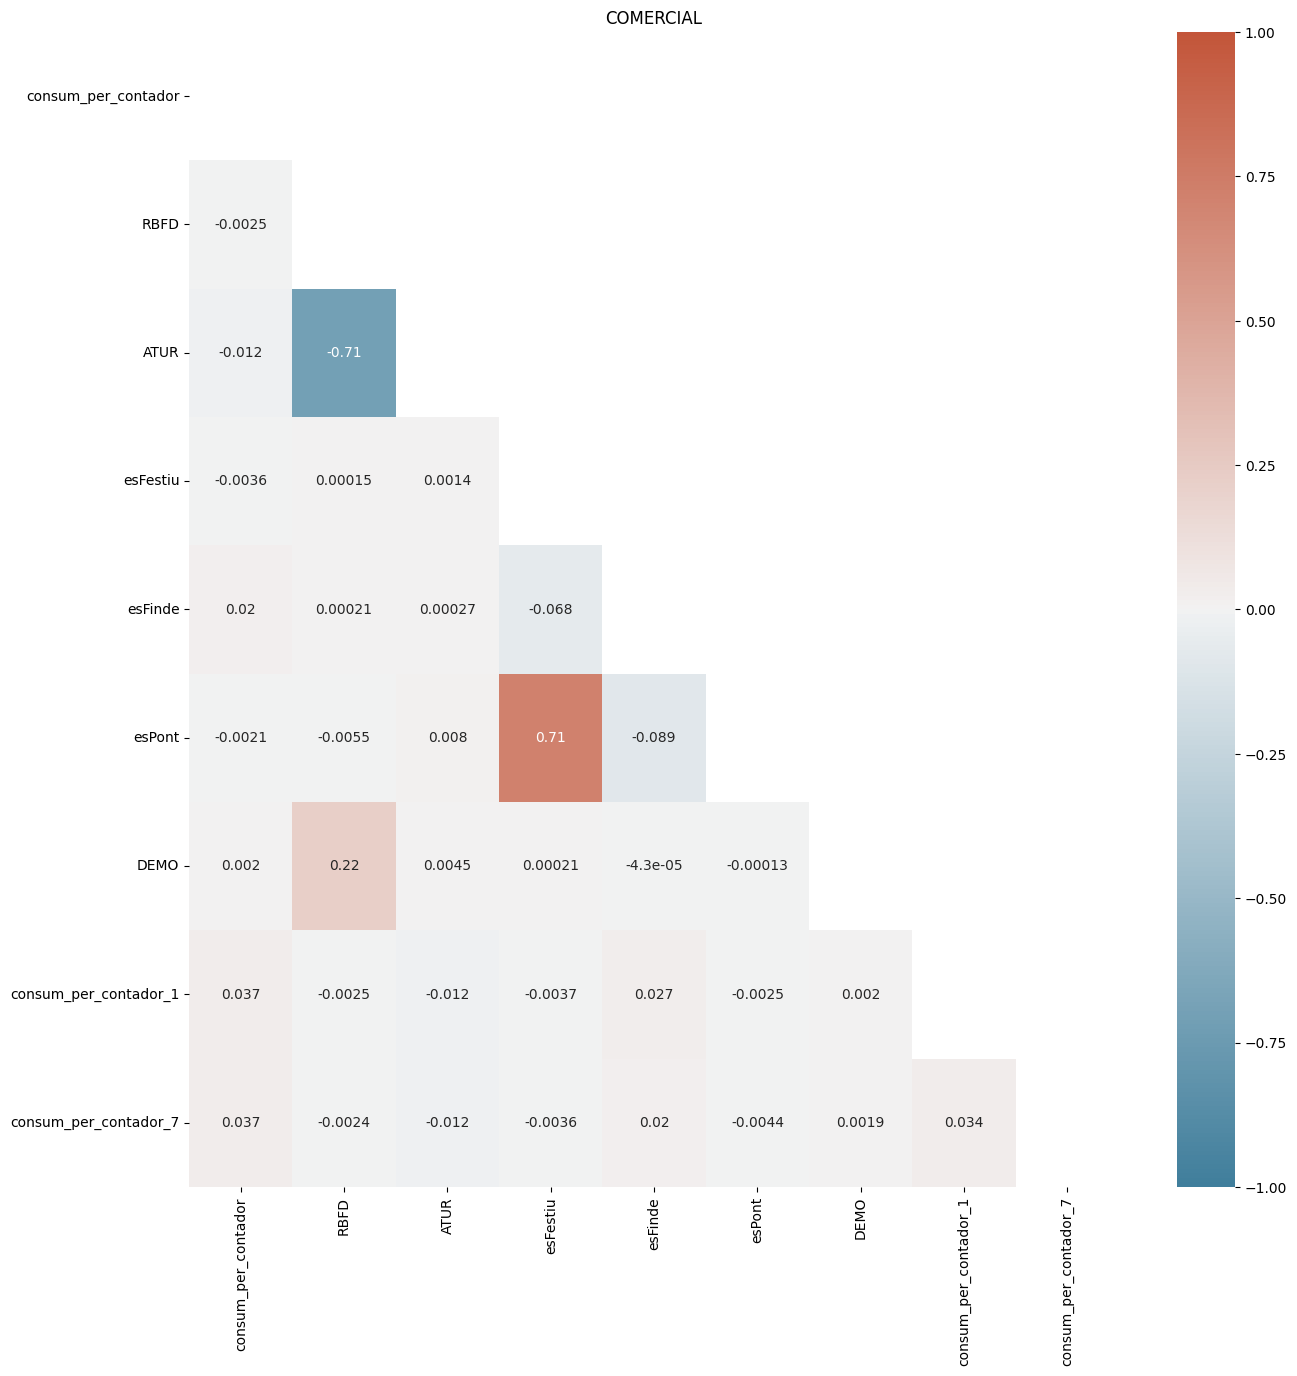

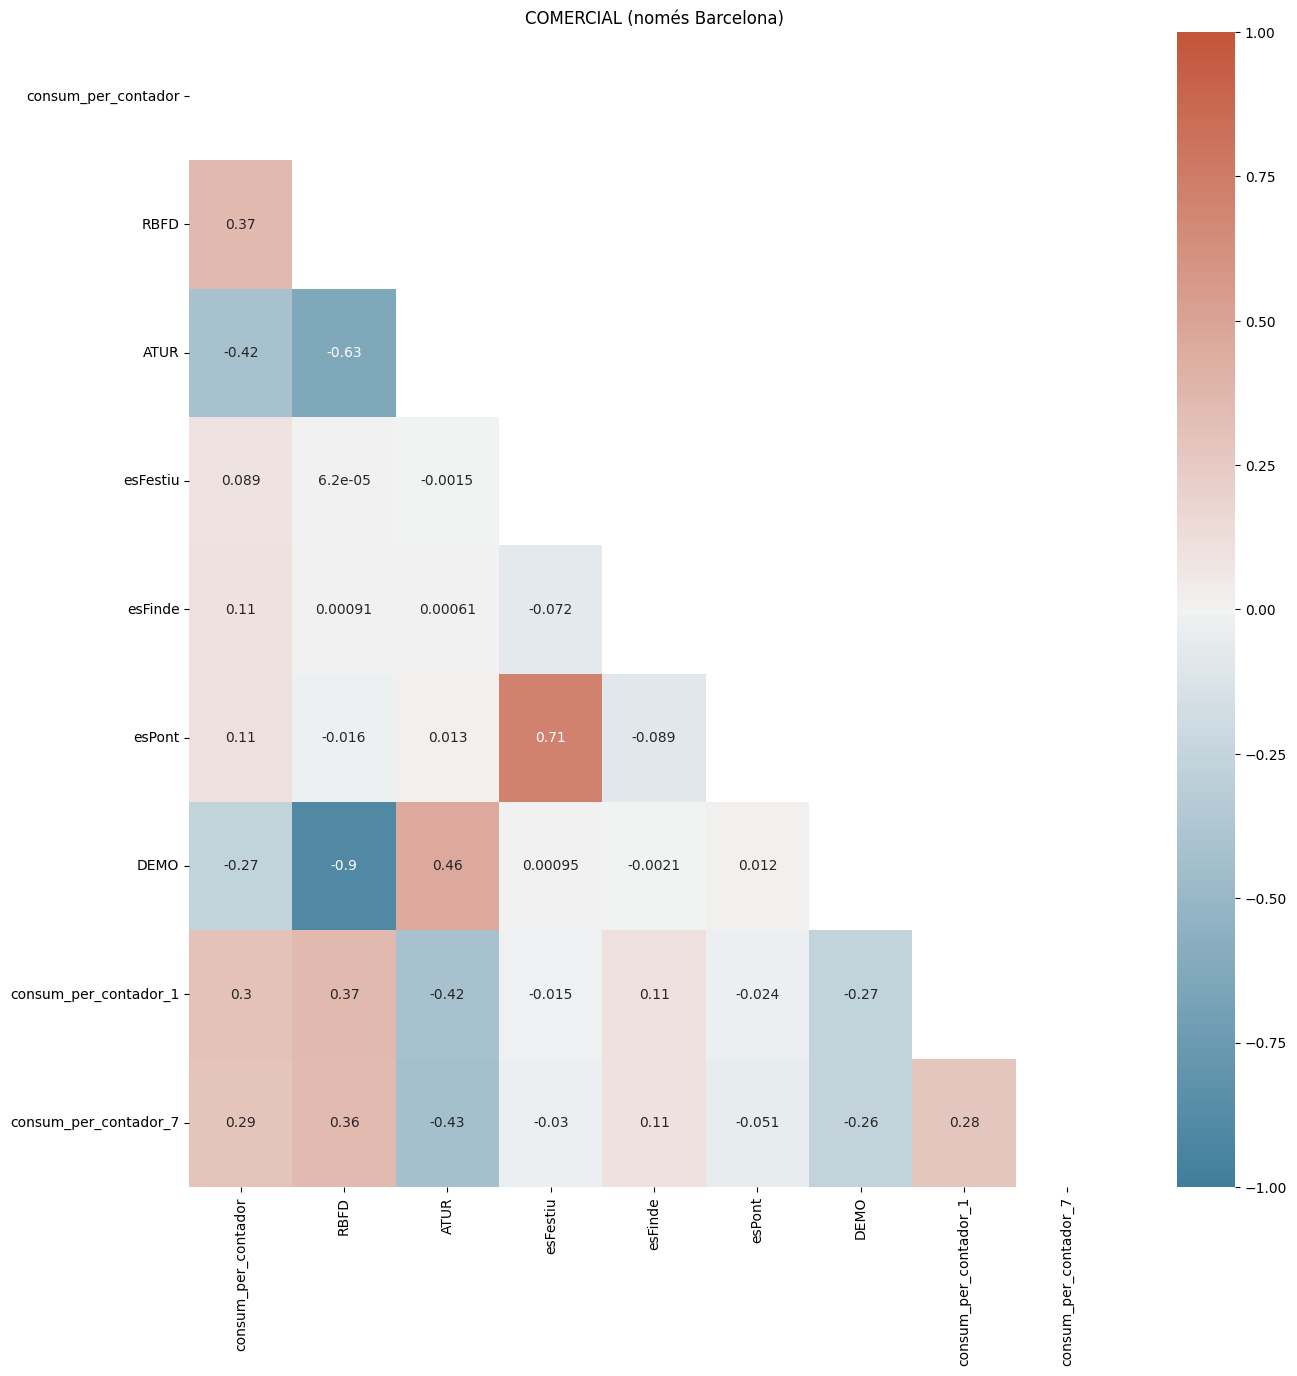

In [17]:
# COMERCIAL
df = pd.concat(list(lagged_COMERCIAL_name2df.values()))
df_heatmap = df[['consum_per_contador', 'RBFD', 'ATUR', 'esFestiu', 'esFinde', 'esPont', 'DEMO', 'consum_per_contador_1', 'consum_per_contador_7']].copy()
fig, axes = plt.subplots(1,1,figsize=(15,15))
corr=df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax= axes, annot=True, vmin=-1, vmax=1)
plt.title("COMERCIAL")
plt.show()

df = lagged_COMERCIAL_name2df["BARCELONA"]
df_heatmap = df[['consum_per_contador', 'RBFD', 'ATUR', 'esFestiu', 'esFinde', 'esPont', 'DEMO', 'consum_per_contador_1', 'consum_per_contador_7']].copy()
fig, axes = plt.subplots(1,1,figsize=(15,15))
corr=df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax= axes, annot=True, vmin=-1, vmax=1)
plt.title("COMERCIAL (només Barcelona)")
plt.show()

Podem observar com les correlacions globalment no son gaire fortes, tot i que si les mirem dins de un municipi en concret, trobem relacions que tenen mes sentit. Podem observar que l'any que hi ha hagut una RBFD mes elevada, hi ha hagut mes consum d'aigua. Al tenir una economia millor, els comerços utilitzaven mes aigua. En canvi, aquells anys on hi ha mes atur, els comerços van pitjor, i consumeixen menys aigua.

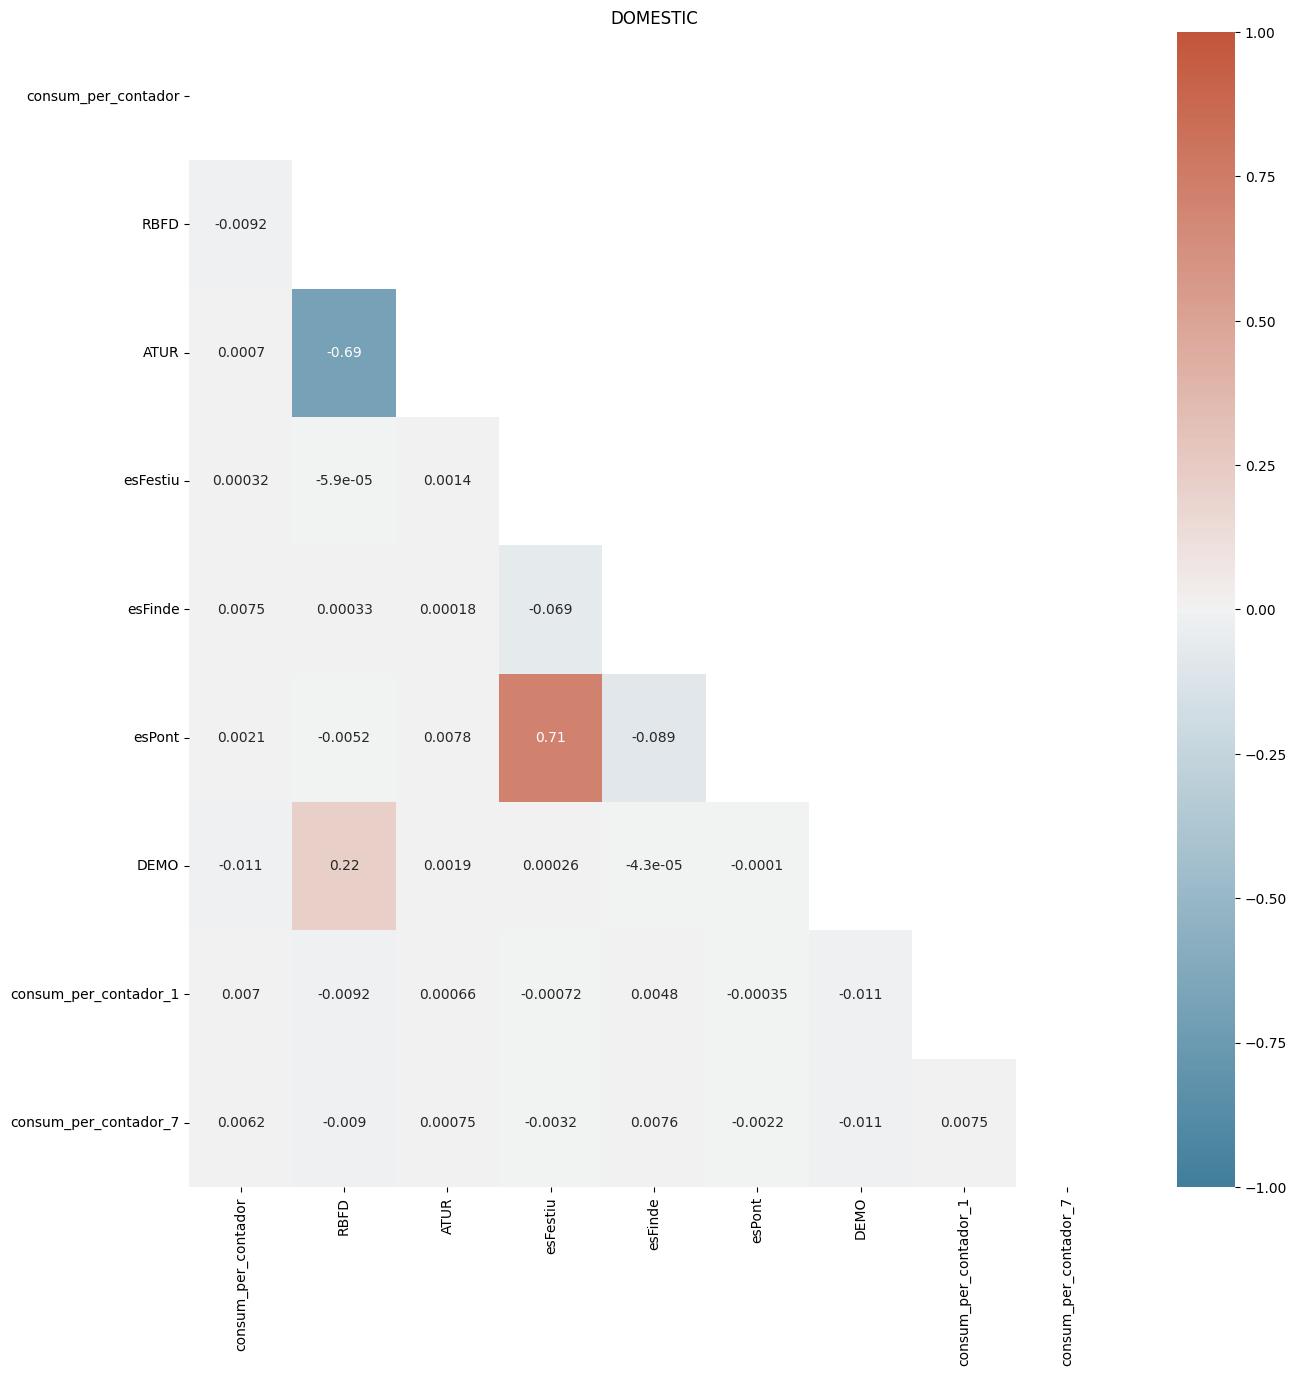

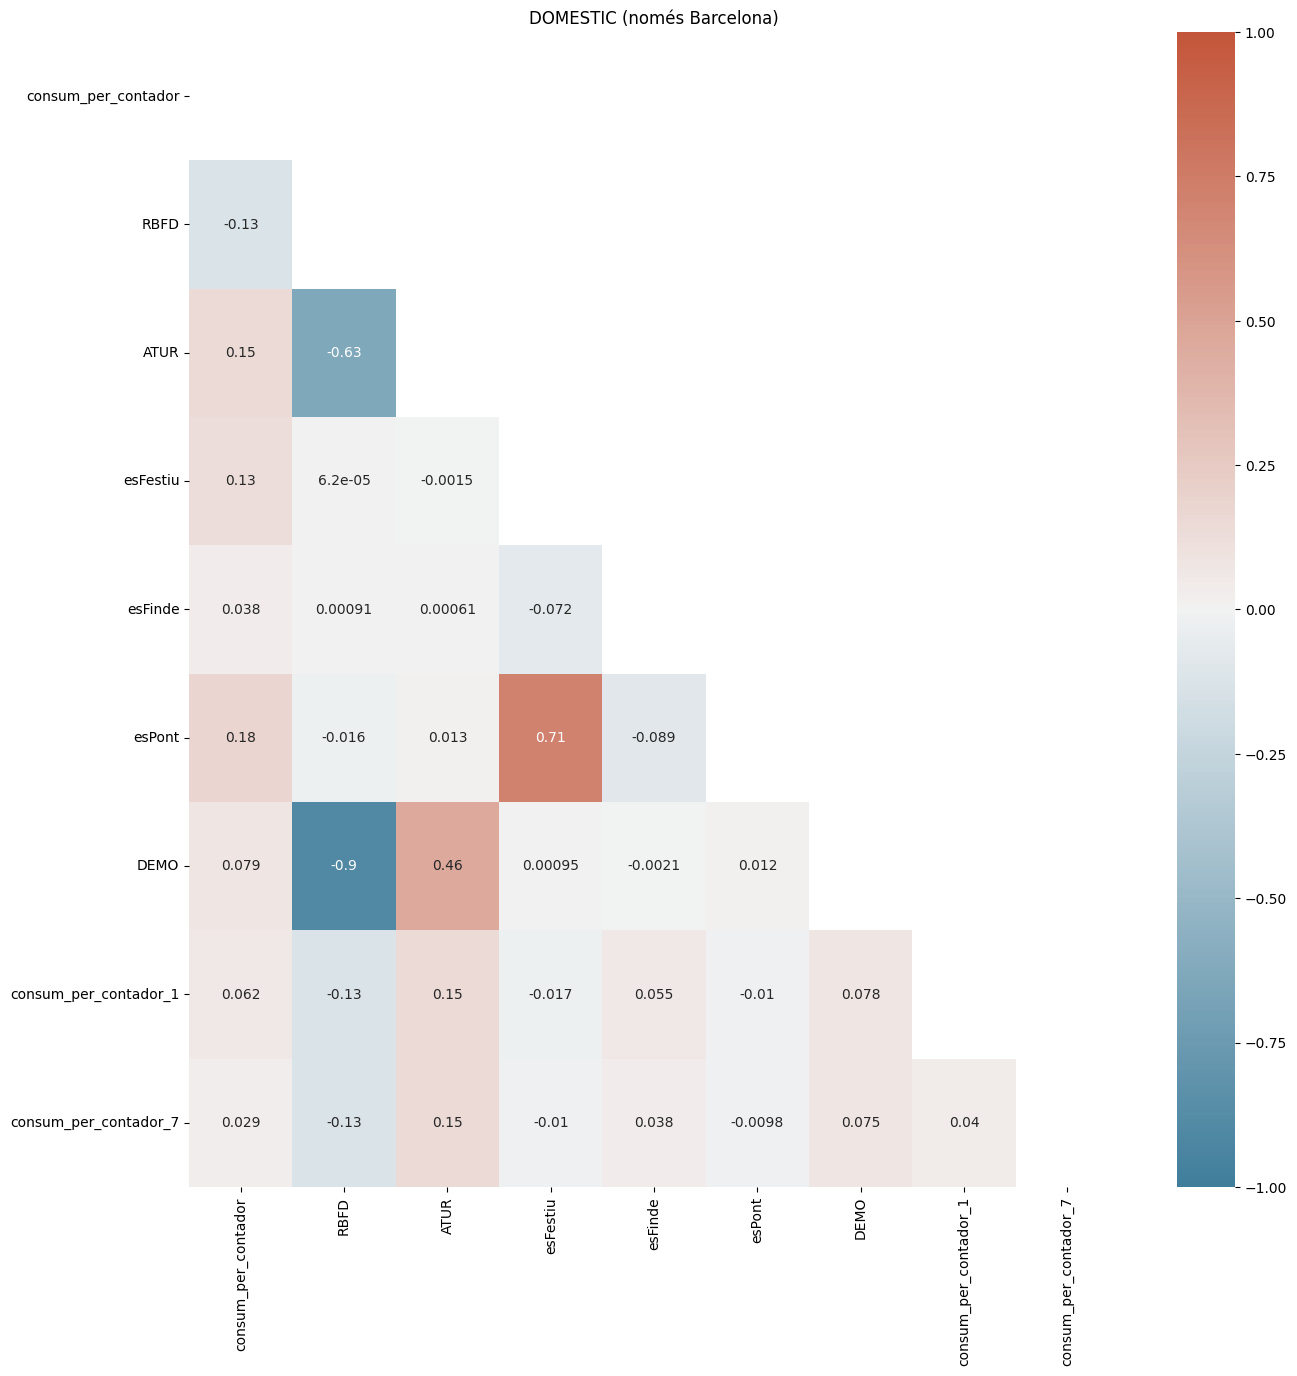

In [18]:
# DOMESTIC
df = pd.concat(list(lagged_DOMESTIC_name2df.values()))
df_heatmap = df[['consum_per_contador', 'RBFD', 'ATUR', 'esFestiu', 'esFinde', 'esPont', 'DEMO', 'consum_per_contador_1', 'consum_per_contador_7']].copy()
fig, axes = plt.subplots(1,1,figsize=(15,15))
corr=df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax= axes, annot=True, vmin=-1, vmax=1)
plt.title("DOMESTIC")
plt.show()

df = lagged_DOMESTIC_name2df["BARCELONA"]
df_heatmap = df[['consum_per_contador', 'RBFD', 'ATUR', 'esFestiu', 'esFinde', 'esPont', 'DEMO', 'consum_per_contador_1', 'consum_per_contador_7']].copy()
fig, axes = plt.subplots(1,1,figsize=(15,15))
corr=df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax= axes, annot=True, vmin=-1, vmax=1)
plt.title("DOMESTIC (només Barcelona)")
plt.show()

Podem observar com les correlacions globalment no son gaire fortes, tot i que si les mirem dins de un municipi en concret, trobem relacions que tenen mes sentit. Podem observar que l'any que hi ha hagut una RBFD mes elevada, el consum domèstic disminueix, ja que la gent surt més. En canvi, aquells anys on hi ha mes atur, la gent es queda més a casa.

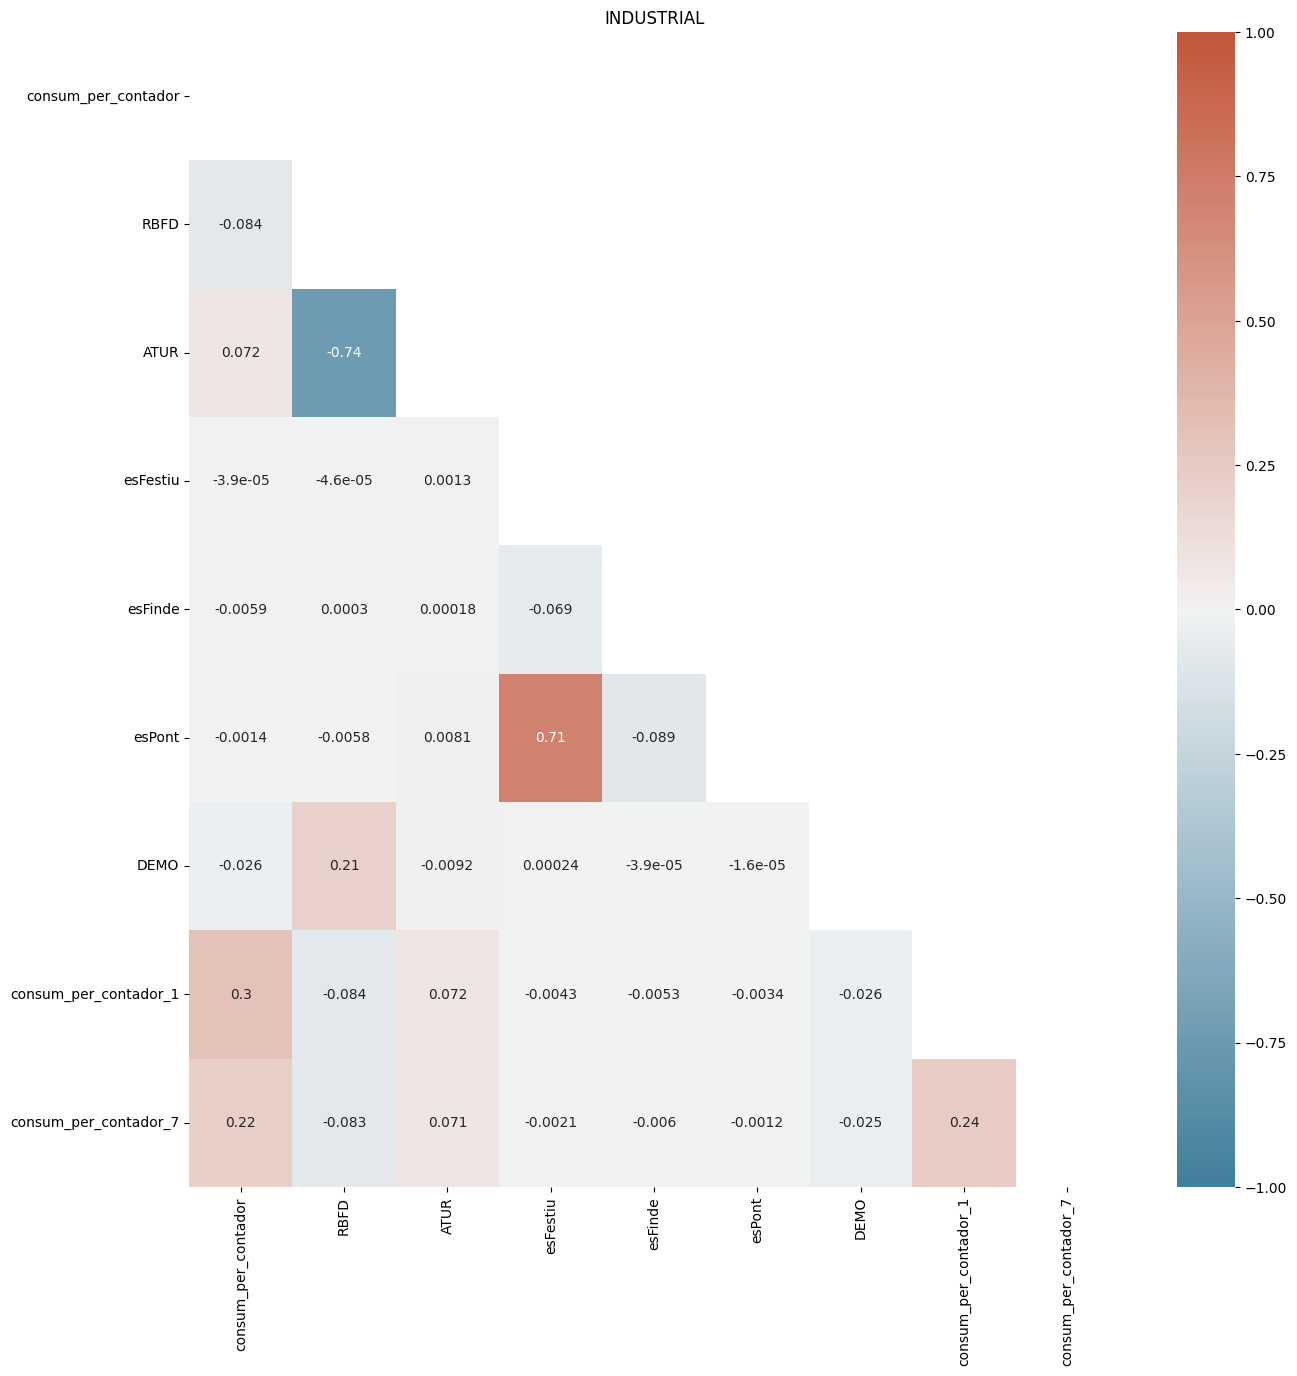

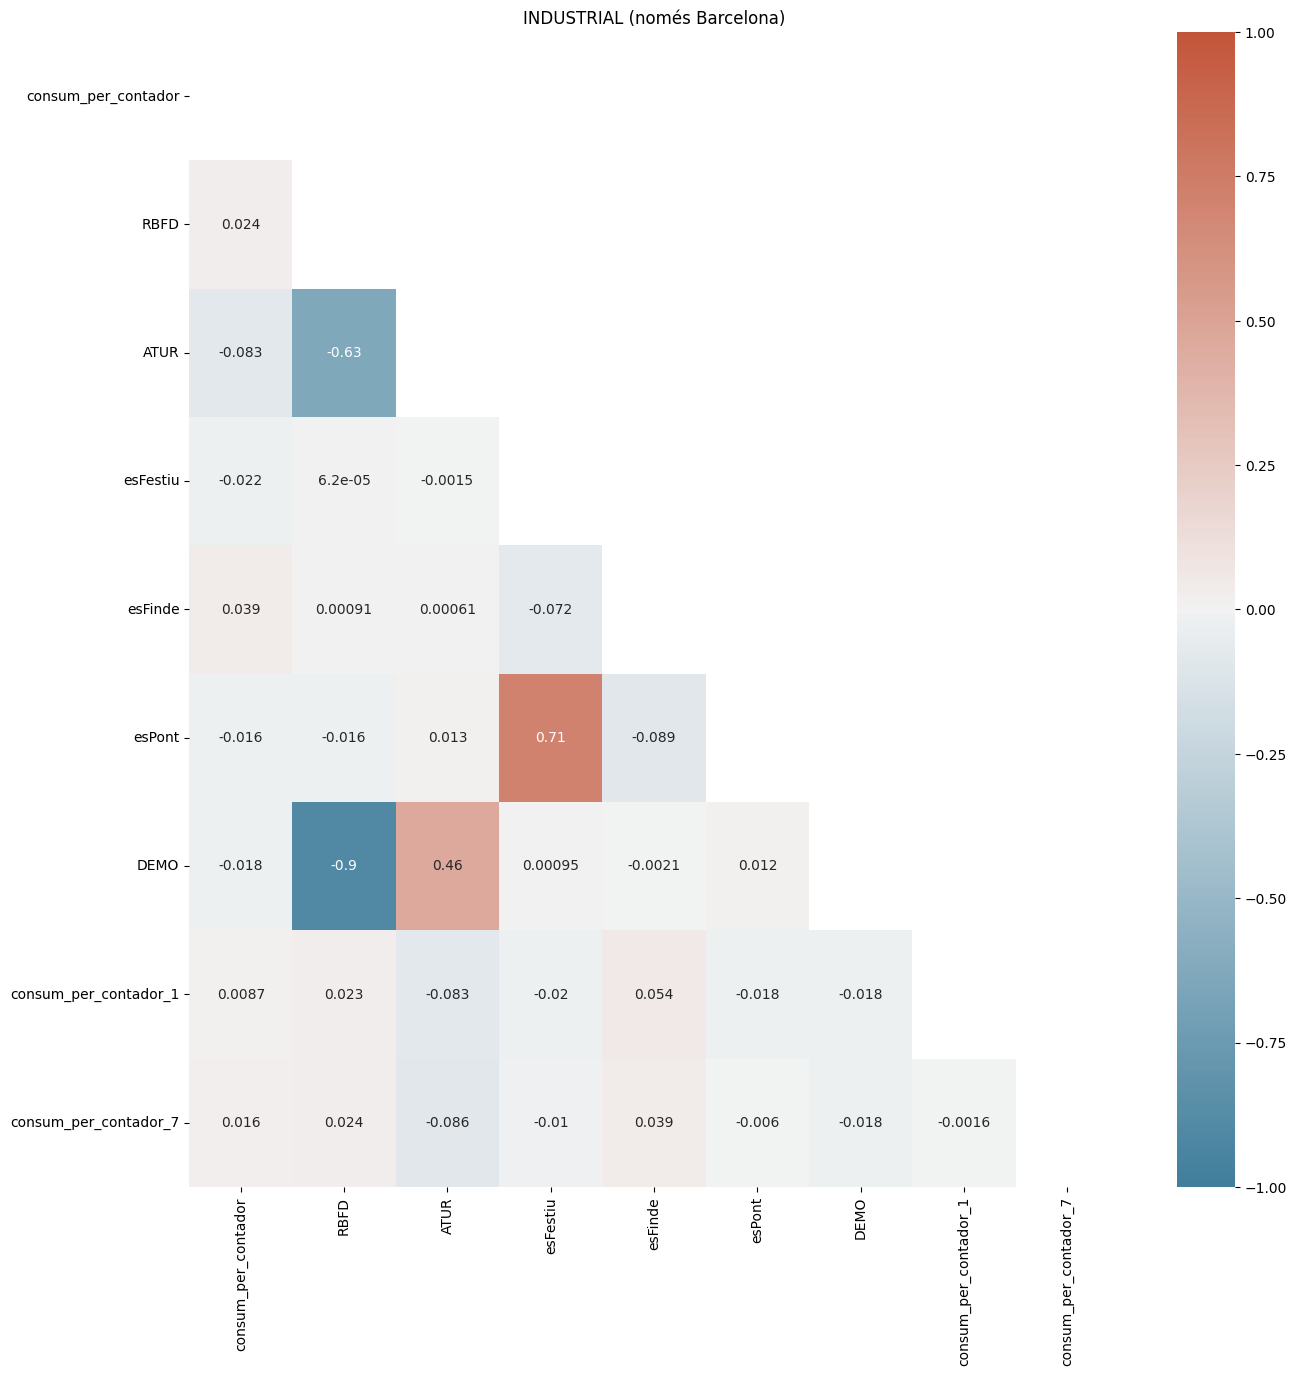

In [19]:
# INDUSTRIAL
df = pd.concat(list(lagged_INDUSTRIAL_name2df.values()))
df_heatmap = df[['consum_per_contador', 'RBFD', 'ATUR', 'esFestiu', 'esFinde', 'esPont', 'DEMO', 'consum_per_contador_1', 'consum_per_contador_7']].copy()
fig, axes = plt.subplots(1,1,figsize=(15,15))
corr=df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax= axes, annot=True, vmin=-1, vmax=1)
plt.title("INDUSTRIAL")
plt.show()

df = lagged_INDUSTRIAL_name2df["BARCELONA"]
df_heatmap = df[['consum_per_contador', 'RBFD', 'ATUR', 'esFestiu', 'esFinde', 'esPont', 'DEMO', 'consum_per_contador_1', 'consum_per_contador_7']].copy()
fig, axes = plt.subplots(1,1,figsize=(15,15))
corr=df_heatmap.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax= axes, annot=True, vmin=-1, vmax=1)
plt.title("INDUSTRIAL (només Barcelona)")
plt.show()

En el cas del consum industrial, podem veure com les correlacions globals son més fortes que les concretes de Barcelona. Això pot ser perquè les industries acostumes a localitzar-se en altres municipis, a les afores de Barcelona. Un altre motiu, pot ser que el consum industrial no depen tant del municipi on se situa, sinò en el tipus activitat industrial. Malgrat això, caldria un anàlisi més profund per poder determinar la validesa d'aquesta hipòtesi..

## Model

Per predir el consum d'aigua, hem decidit utilitzar varis models, un per cada ciutat i tipus de consum.

Primer dividim les dades en ‘report’, ‘test’ i ‘train’ seguint una relació 10-20-70. A continuació, creem el model alimentant les dades de ‘train’ a un XGBRegressor. Per fer l'analisi del model en concret, utilitzem les dades de 'test'.
Finalment, utilitzem les dades de 'report' per veure com el model es capaç de predir a la llarga.

Abans de fer el split de les dades vam decidir borrar aquelles files on no teniem valor pel consum, i per altra banda també vam borrar aquelles columnes que tenien una quantitat de nulls major a l'1% del total de dades.

In [20]:
# Preparing a set of data for doing the report
report_COMERCIAL_name2df = dict()
model_COMERCIAL_name2df = dict()
for name, lagged_df in lagged_COMERCIAL_name2df.items():
    lagged_df = lagged_df.copy()
    lagged_df = lagged_df[lagged_df.consum_per_contador.isna() == False]
    N = len(lagged_df)
    for col in lagged_df.columns.copy():
        if lagged_df[col].isna().sum() > int(N * 0.01):
            lagged_df.drop(columns=(col), inplace=True)
    lagged_df.dropna(inplace=True)
    report_COMERCIAL_name2df[name] = lagged_df.iloc[int(0.9 * N):,:]
    #print(report_COMERCIAL_name2df[name].isna().sum().sum())
    model_COMERCIAL_name2df[name] = lagged_df.iloc[:int(0.9 * N),:]
    model_COMERCIAL_name2df[name] = delete_outliers_IQR(model_COMERCIAL_name2df[name], "consum_per_contador")

report_DOMESTIC_name2df = dict()
model_DOMESTIC_name2df = dict()
for name, lagged_df in lagged_DOMESTIC_name2df.items():
    lagged_df = lagged_df.copy()
    lagged_df = lagged_df[lagged_df.consum_per_contador.isna() == False]
    N = len(lagged_df)
    for col in lagged_df.columns.copy():
        if lagged_df[col].isna().sum() > int(N * 0.01):
            lagged_df.drop(columns=(col), inplace=True)
    lagged_df.dropna(inplace=True)
    report_DOMESTIC_name2df[name] = lagged_df.iloc[int(0.9 * N):,:]
    #print(report_DOMESTIC_name2df[name].isna().sum().sum())
    model_DOMESTIC_name2df[name] = lagged_df.iloc[:int(0.9 * N),:]
    model_DOMESTIC_name2df[name] = delete_outliers_IQR(model_DOMESTIC_name2df[name], "consum_per_contador")

report_INDUSTRIAL_name2df = dict()
model_INDUSTRIAL_name2df = dict()
for name, lagged_df in lagged_INDUSTRIAL_name2df.items():
    lagged_df = lagged_df.copy()
    lagged_df = lagged_df[lagged_df.consum_per_contador.isna() == False]
    N = len(lagged_df)
    for col in lagged_df.columns.copy():
        if lagged_df[col].isna().sum() > int(N * 0.01):
            lagged_df.drop(columns=(col), inplace=True)
    lagged_df.dropna(inplace=True)
    report_INDUSTRIAL_name2df[name] = lagged_df.iloc[int(0.9 * N):,:]
    #print(report_INDUSTRIAL_name2df[name].isna().sum().sum())
    model_INDUSTRIAL_name2df[name] = lagged_df.iloc[:int(0.9 * N),:]
    model_INDUSTRIAL_name2df[name] = delete_outliers_IQR(model_INDUSTRIAL_name2df[name], "consum_per_contador")

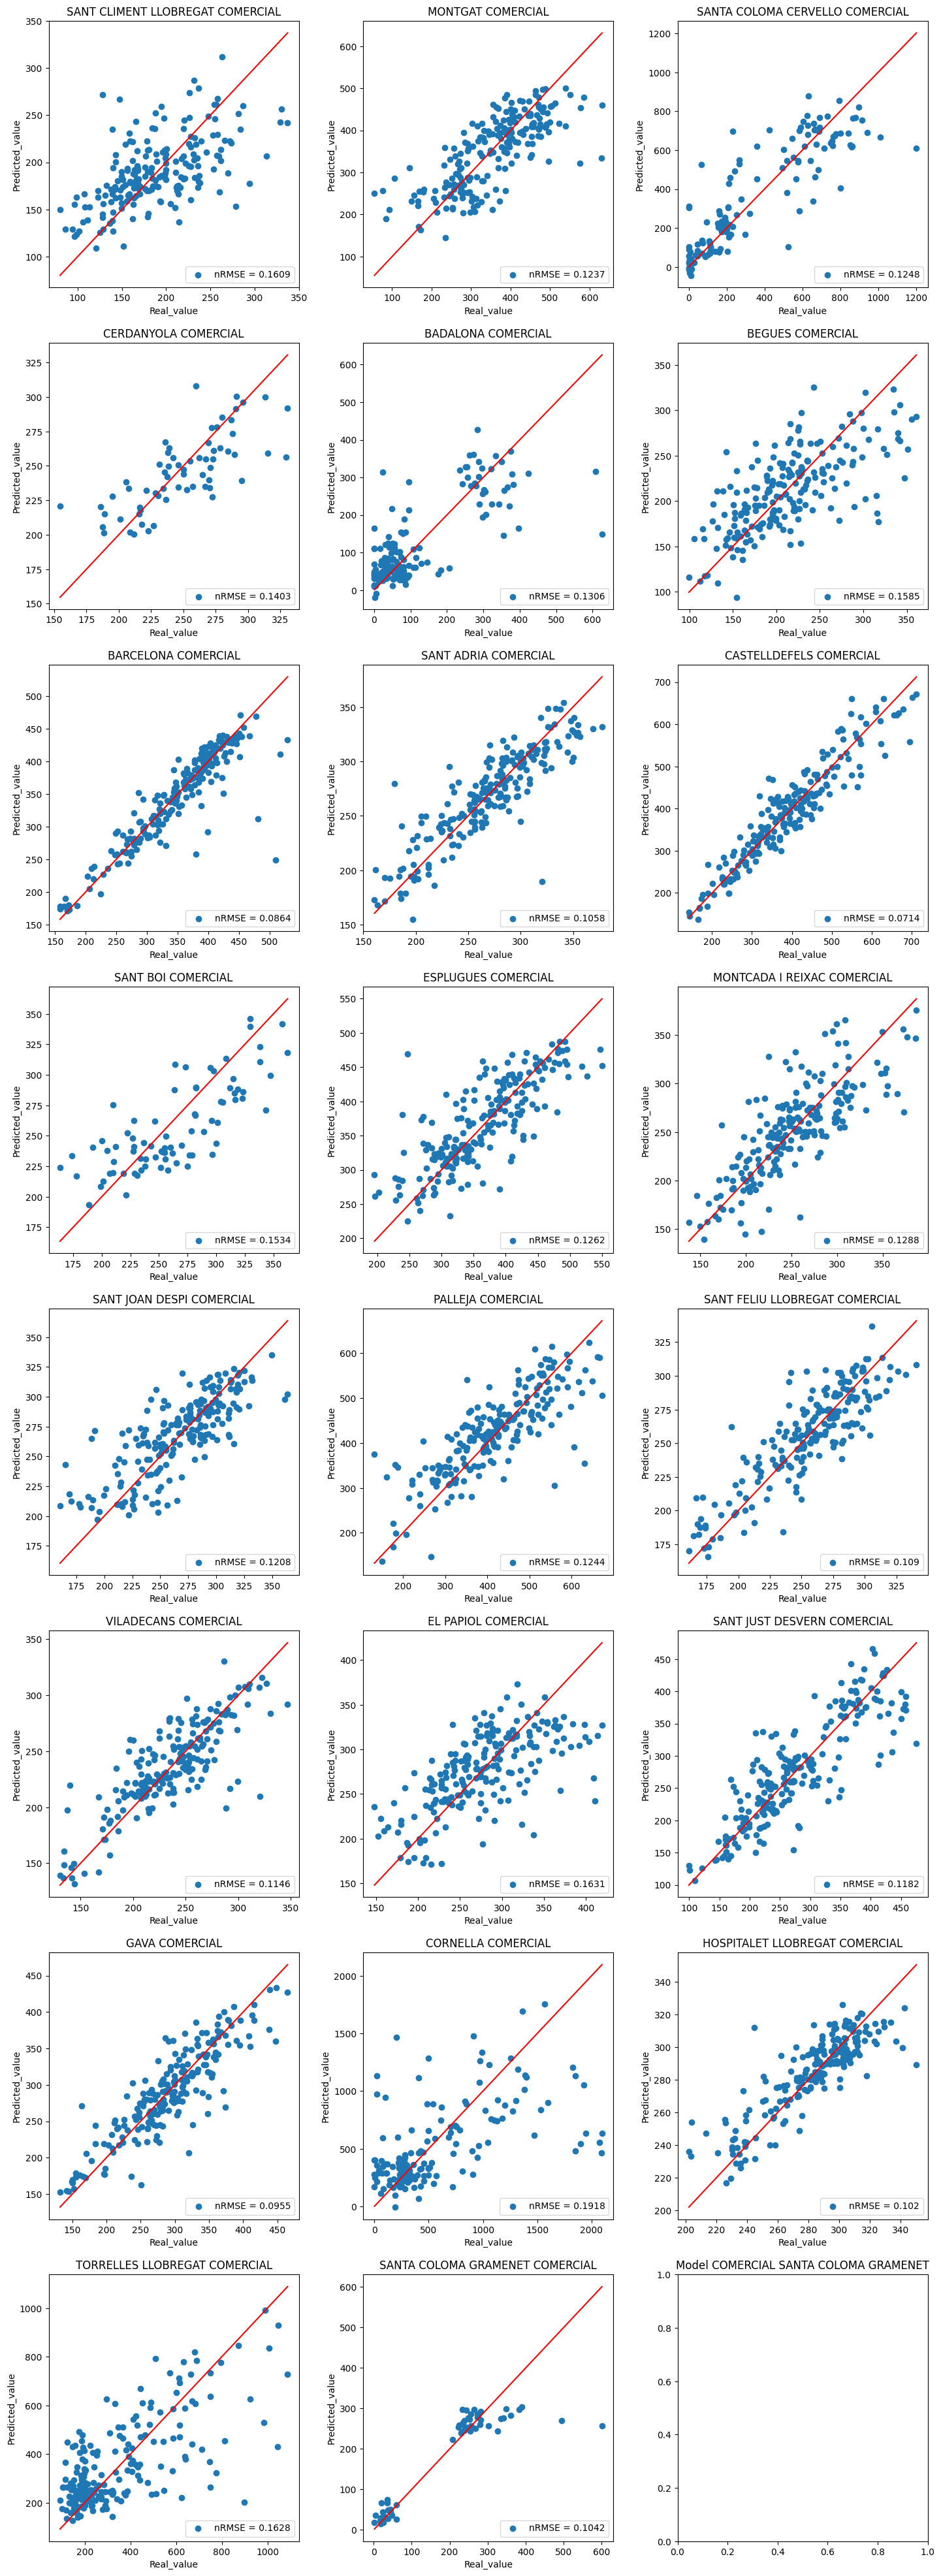

In [21]:
Y_COMERCIAL_global = list()
Y_COMERCIAL_pred_global = list()

N = len(model_COMERCIAL_name2df)
fig, ax = plt.subplots(int(np.ceil(N / 3)), 3, figsize=(15, 40))
plt.tight_layout(pad=4)

for name, df in model_COMERCIAL_name2df.items():
    X = df.drop(columns=("consum_per_contador"))
    y = df.consum_per_contador
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_standard = scaler.transform(X_train)
    X_test_standard = scaler.transform(X_test)
    xgbr = XGBRegressor(n_estimators=25, max_depth=6, tree_method="hist", min_child_weight=10)
    model = xgbr.fit(X_train_standard, y_train)
    Y = xgbr.predict(X_test_standard)
    Y_COMERCIAL_global += list(y_test)
    Y_COMERCIAL_pred_global += list(Y)
    
    
    nRMSE = np.sqrt(mean_squared_error(list(y_test), list(Y)))/(np.max(y_test)-np.min(y_test))
    
    plt.title('Model COMERCIAL ' + name)
    index = list(model_COMERCIAL_name2df.keys()).index(name)
    ax[index // 3, index % 3].scatter(y_test, Y, label = f"nRMSE = {round(nRMSE, 4)}")
    ax[index // 3, index % 3].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c="r")
    ax[index // 3, index % 3].legend(loc="lower right")
    ax[index // 3, index % 3].set_title(f"{name} COMERCIAL")
    ax[index // 3, index % 3].set_xlabel("Real_value")
    ax[index // 3, index % 3].set_ylabel("Predicted_value")
    #We save the model
    filename = f'models/{name}_COMERCIAL.sav'
    pickle.dump(xgbr, open(filename, 'wb'))
    
    filename = f'models/{name}_COMERCIAL_scaler.sav'
    pickle.dump(scaler, open(filename, 'wb'))
plt.show()

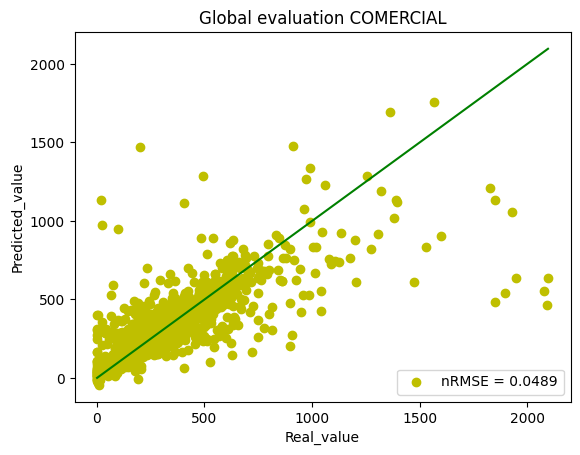

In [22]:
nRMSE = np.sqrt(mean_squared_error(list(Y_COMERCIAL_global), list(Y_COMERCIAL_pred_global)))/(np.max(Y_COMERCIAL_global)-np.min(Y_COMERCIAL_global))

plt.title('Global evaluation COMERCIAL')
plt.scatter(Y_COMERCIAL_global, Y_COMERCIAL_pred_global, c="y", label = f"nRMSE = {round(nRMSE, 4)}")
plt.plot([min(Y_COMERCIAL_global), max(Y_COMERCIAL_global)],[min(Y_COMERCIAL_global), max(Y_COMERCIAL_global)], c="g")
plt.xlabel("Real_value")
plt.ylabel("Predicted_value")
plt.legend(loc="lower right")
plt.show()

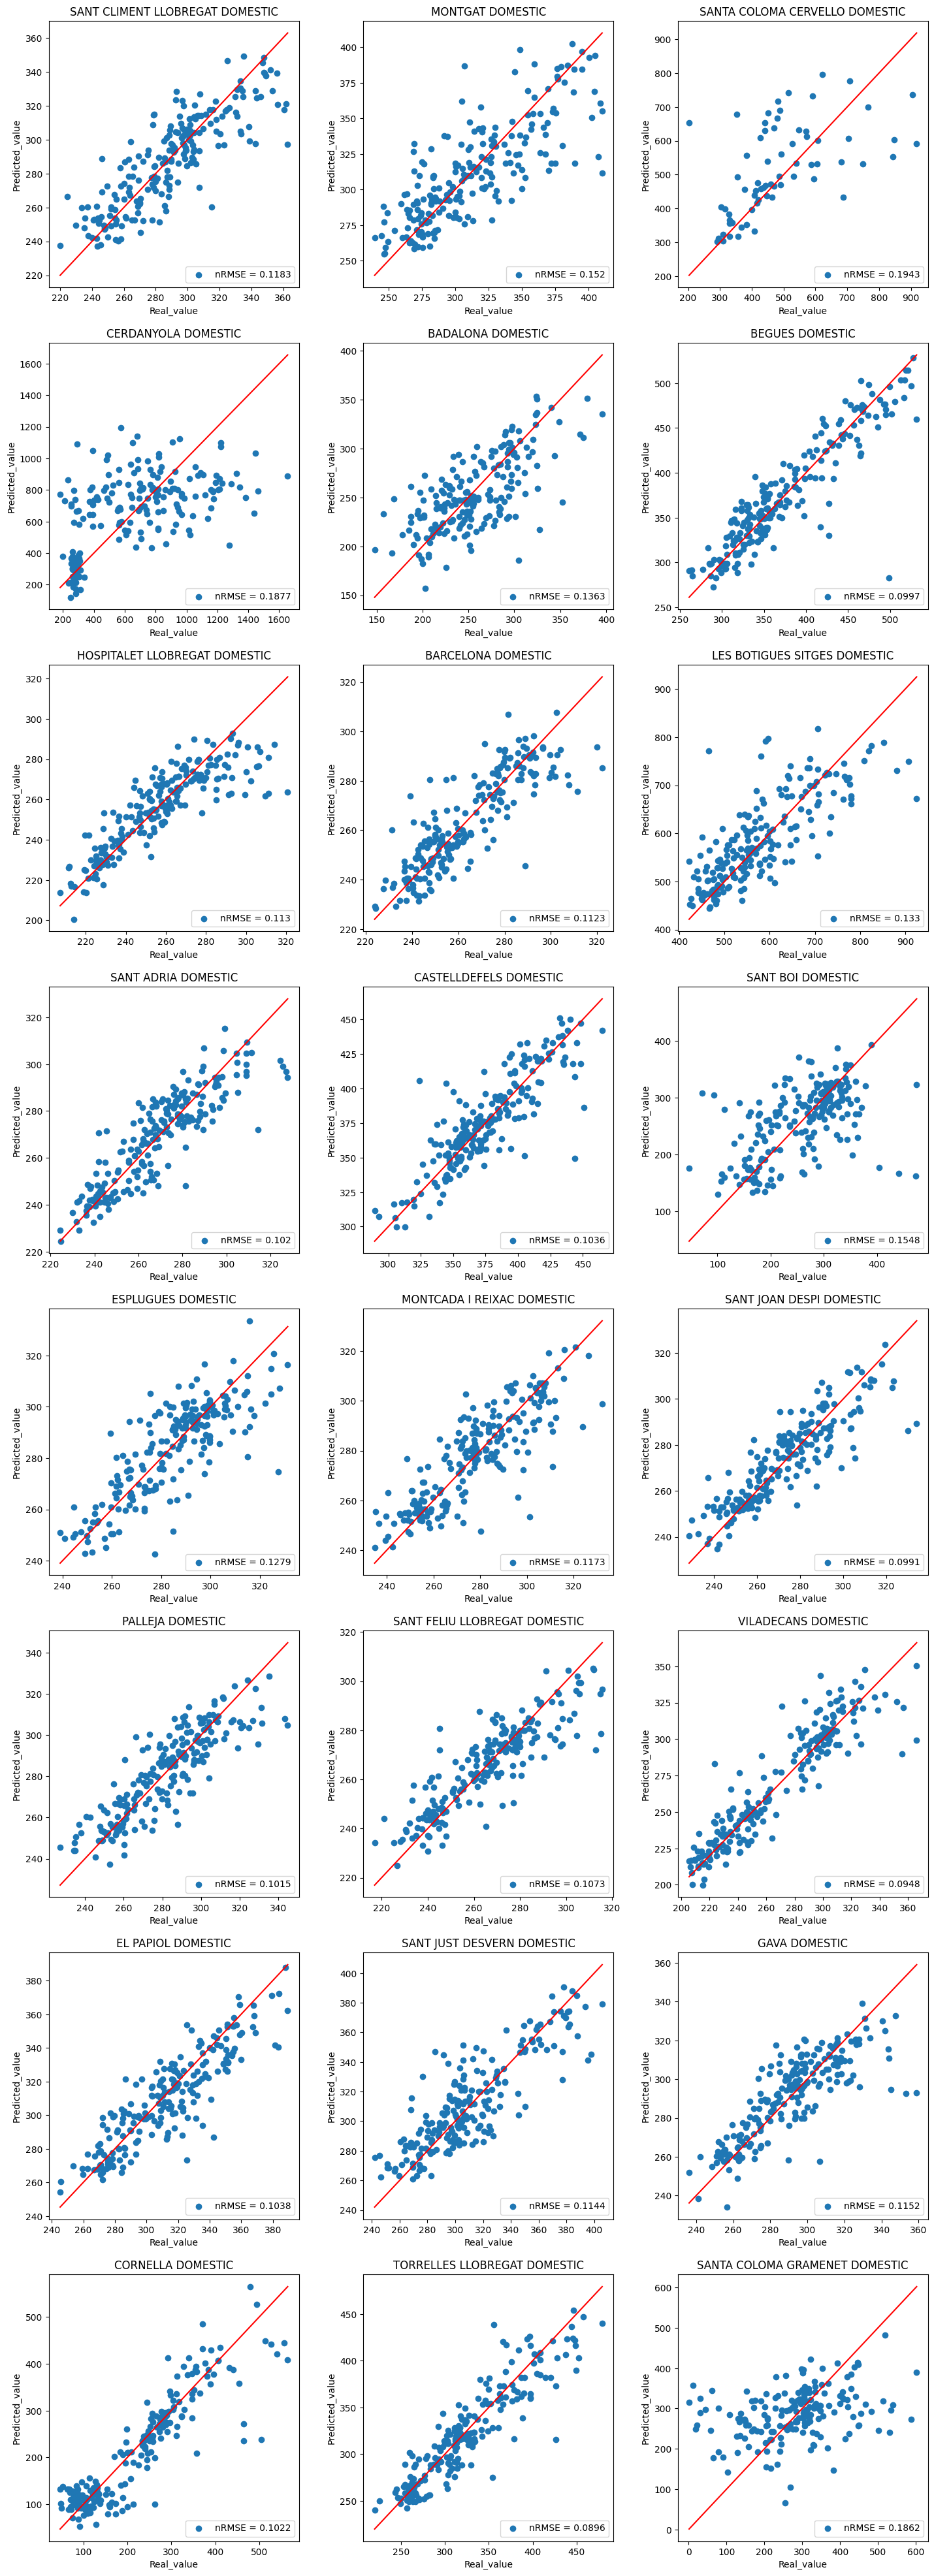

In [23]:
Y_DOMESTIC_global = list()
Y_DOMESTIC_pred_global = list()

N = len(model_DOMESTIC_name2df)
fig, ax = plt.subplots(int(np.ceil(N / 3)), 3, figsize=(15, 40))
plt.tight_layout(pad=4)

for name, df in model_DOMESTIC_name2df.items():
    X = df.drop(columns=("consum_per_contador"))
    y = df.consum_per_contador
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_standard = scaler.transform(X_train)
    X_test_standard = scaler.transform(X_test)
    xgbr = XGBRegressor(n_estimators=25, max_depth=6, tree_method="hist", min_child_weight=10)
    model = xgbr.fit(X_train_standard, y_train)
    Y = xgbr.predict(X_test_standard)
    Y_DOMESTIC_global += list(y_test)
    Y_DOMESTIC_pred_global += list(Y)
    
    
    nRMSE = np.sqrt(mean_squared_error(list(y_test), list(Y)))/(np.max(y_test)-np.min(y_test))
    
    plt.title('Model DOMESTIC ' + name)
    index = list(model_DOMESTIC_name2df.keys()).index(name)
    ax[index // 3, index % 3].scatter(y_test, Y, label = f"nRMSE = {round(nRMSE, 4)}")
    ax[index // 3, index % 3].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c="r")
    ax[index // 3, index % 3].legend(loc="lower right")
    ax[index // 3, index % 3].set_title(f"{name} DOMESTIC")
    ax[index // 3, index % 3].set_xlabel("Real_value")
    ax[index // 3, index % 3].set_ylabel("Predicted_value")
    #We save the model
    filename = f'models/{name}_DOMESTIC.sav'
    pickle.dump(xgbr, open(filename, 'wb'))
    
    filename = f'models/{name}_DOMESTIC_scaler.sav'
    pickle.dump(scaler, open(filename, 'wb'))
plt.show()

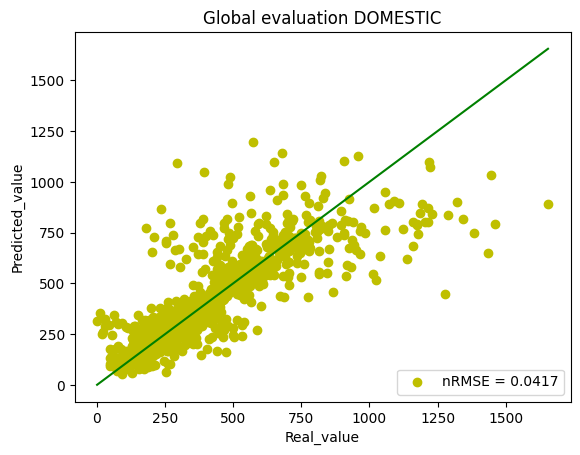

In [24]:
nRMSE = np.sqrt(mean_squared_error(list(Y_DOMESTIC_global), list(Y_DOMESTIC_pred_global)))/(np.max(Y_DOMESTIC_global)-np.min(Y_DOMESTIC_global))

plt.title('Global evaluation DOMESTIC')
plt.scatter(Y_DOMESTIC_global, Y_DOMESTIC_pred_global, c="y", label = f"nRMSE = {round(nRMSE, 4)}")
plt.plot([min(Y_DOMESTIC_global), max(Y_DOMESTIC_global)],[min(Y_DOMESTIC_global), max(Y_DOMESTIC_global)], c="g")
plt.xlabel("Real_value")
plt.ylabel("Predicted_value")
plt.legend(loc="lower right")
plt.show()

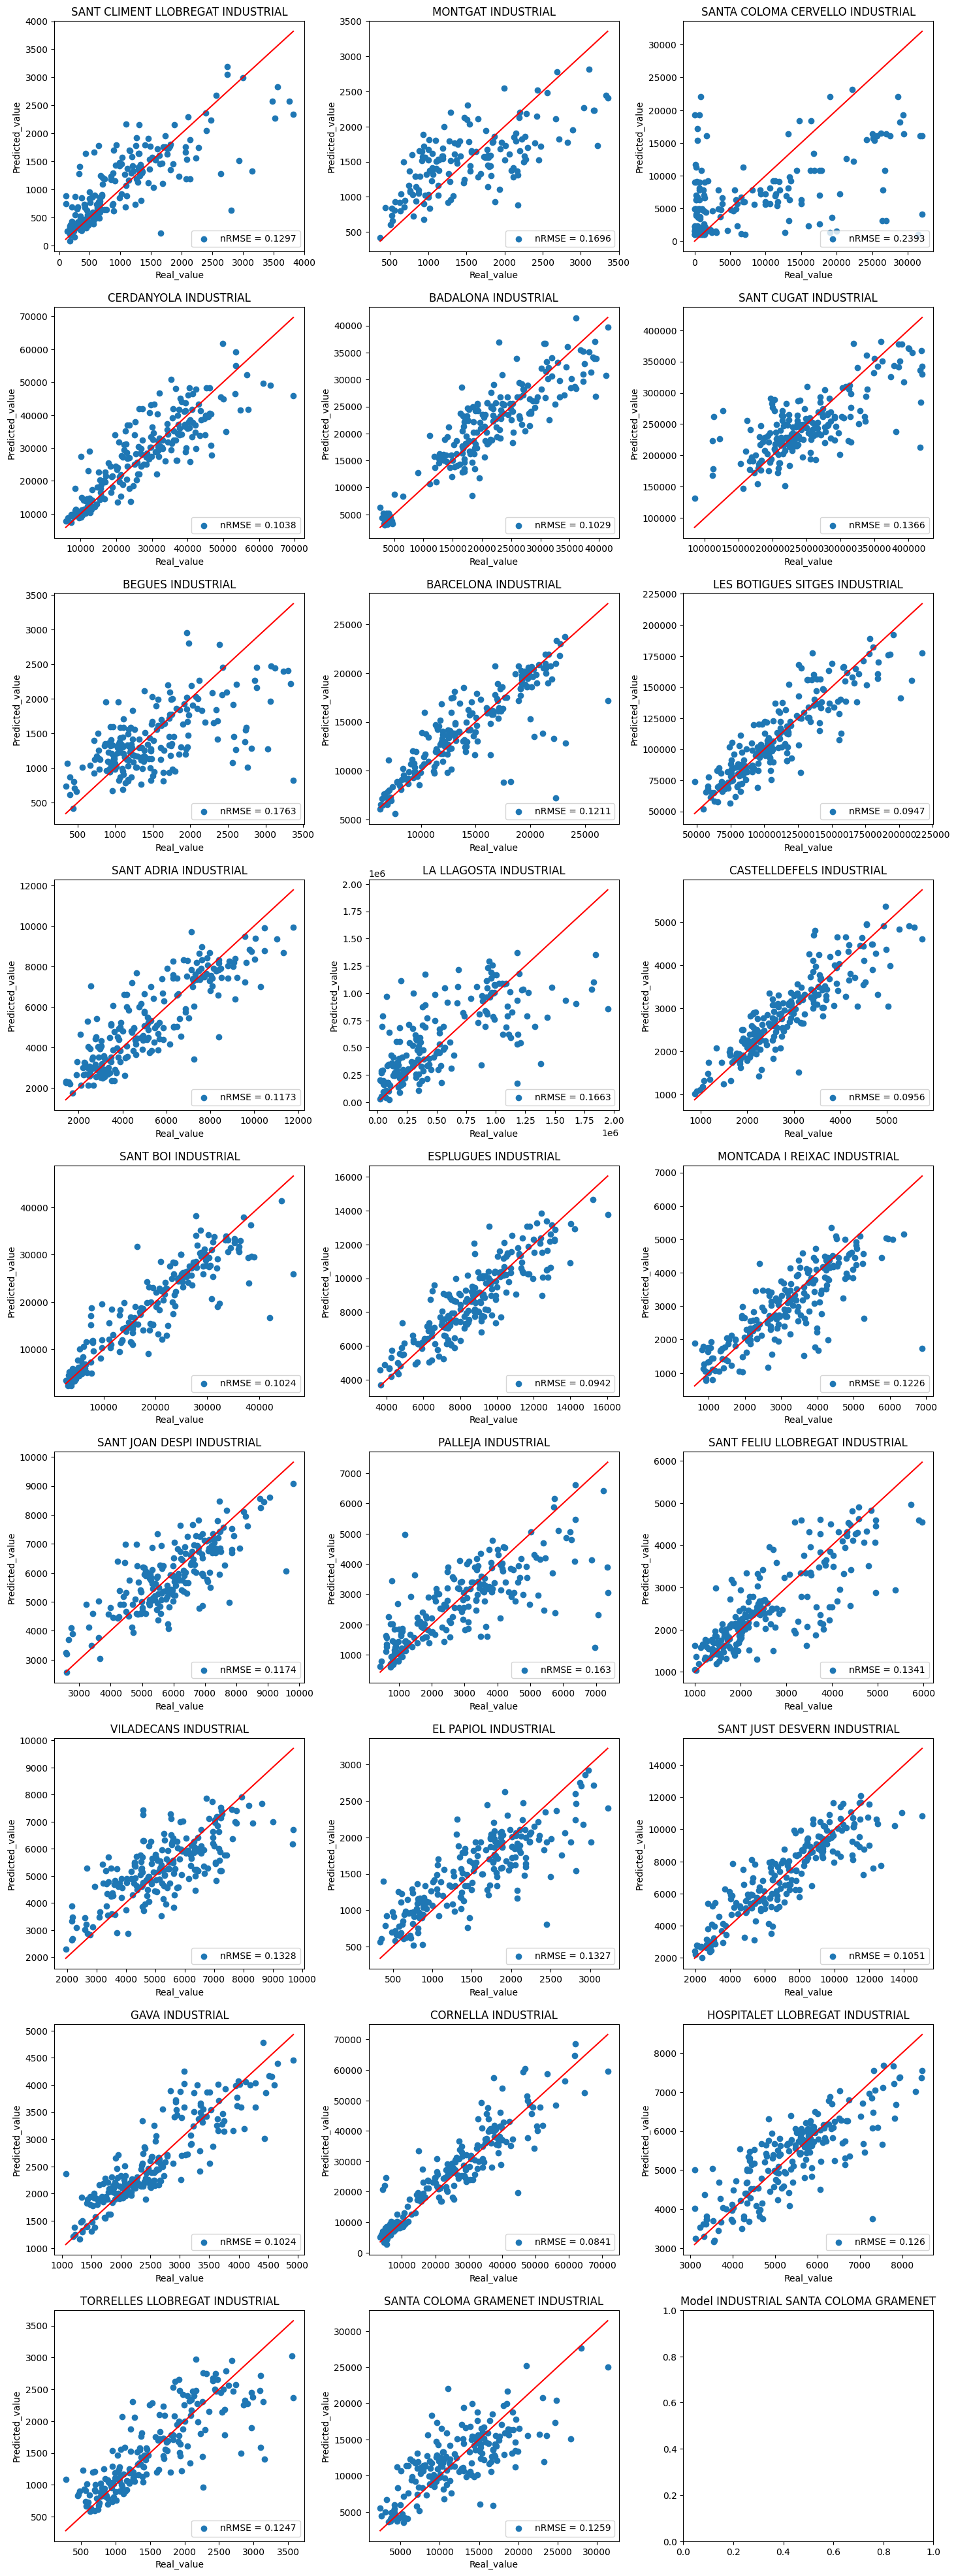

In [25]:
Y_INDUSTRIAL_global = list()
Y_INDUSTRIAL_pred_global = list()

N = len(model_INDUSTRIAL_name2df)
fig, ax = plt.subplots(int(np.ceil(N / 3)), 3, figsize=(15, 40))
plt.tight_layout(pad=4)

for name, df in model_INDUSTRIAL_name2df.items():
    X = df.drop(columns=("consum_per_contador"))
    y = df.consum_per_contador
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_standard = scaler.transform(X_train)
    X_test_standard = scaler.transform(X_test)
    xgbr = XGBRegressor(n_estimators=25, max_depth=6, tree_method="hist", min_child_weight=10)
    model = xgbr.fit(X_train_standard, y_train)
    Y = xgbr.predict(X_test_standard)
    Y_INDUSTRIAL_global += list(y_test)
    Y_INDUSTRIAL_pred_global += list(Y)
    
    
    nRMSE = np.sqrt(mean_squared_error(list(y_test), list(Y)))/(np.max(y_test)-np.min(y_test))
    
    plt.title('Model INDUSTRIAL ' + name)
    index = list(model_INDUSTRIAL_name2df.keys()).index(name)
    ax[index // 3, index % 3].scatter(y_test, Y, label = f"nRMSE = {round(nRMSE, 4)}")
    ax[index // 3, index % 3].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c="r")
    ax[index // 3, index % 3].legend(loc="lower right")
    ax[index // 3, index % 3].set_title(f"{name} INDUSTRIAL")
    ax[index // 3, index % 3].set_xlabel("Real_value")
    ax[index // 3, index % 3].set_ylabel("Predicted_value")
    #We save the model
    filename = f'models/{name}_INDUSTRIAL.sav'
    pickle.dump(xgbr, open(filename, 'wb'))
    
    filename = f'models/{name}_INDUSTRIAL_scaler.sav'
    pickle.dump(scaler, open(filename, 'wb'))
plt.show()

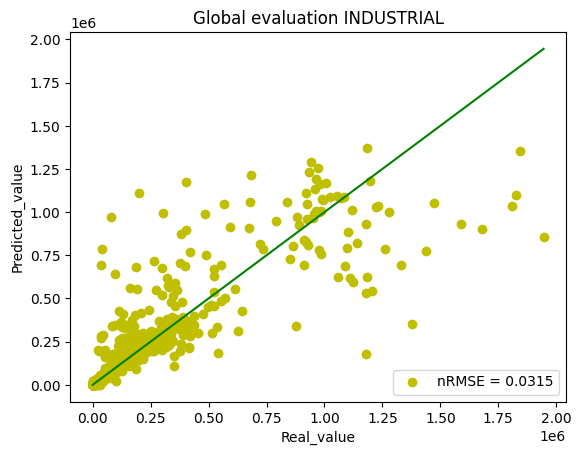

In [26]:
nRMSE = np.sqrt(mean_squared_error(list(Y_INDUSTRIAL_global), list(Y_INDUSTRIAL_pred_global)))/(np.max(Y_INDUSTRIAL_global)-np.min(Y_INDUSTRIAL_global))

plt.title('Global evaluation INDUSTRIAL')
plt.scatter(Y_INDUSTRIAL_global, Y_INDUSTRIAL_pred_global, c="y", label = f"nRMSE = {round(nRMSE, 4)}")
plt.plot([min(Y_INDUSTRIAL_global), max(Y_INDUSTRIAL_global)],[min(Y_INDUSTRIAL_global), max(Y_INDUSTRIAL_global)], c="g")
plt.xlabel("Real_value")
plt.ylabel("Predicted_value")
plt.legend(loc="lower right")
plt.show()

## Explicació del model

Per interpretar com es comporta el nostre model utilitzarem una biblioteca anomenada SHAP. Amb aquesta biblioteca podem explicar la contribució de cada característica a un valor predit individual.

Hem especificat una random seed, de tal manera que sempre es vegi el mateix plot i que per tant els nostres comentaris siguin coherents amb el plots.

In [27]:
def load_model(tipus, municipi):
    with open(f'models/{municipi}_{tipus}.sav', 'rb') as file:
        data = pickle.load(file)
    return data

### Comercial

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


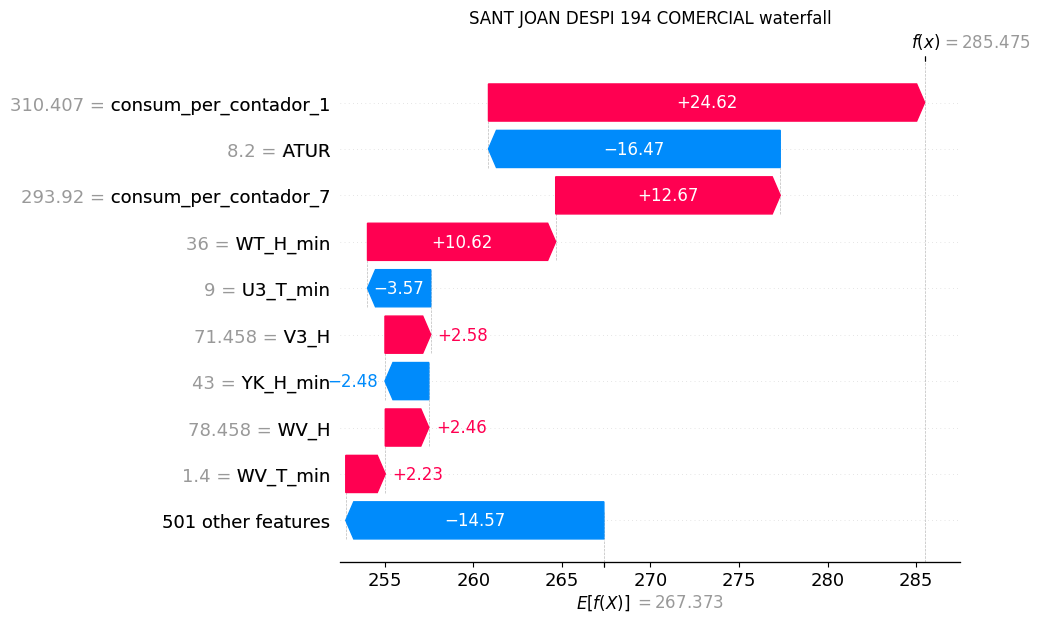

Real value: 291.0810419681621


In [28]:
random.seed(0)

# Choose a random city
random_city = random.choice(list(model_COMERCIAL_name2df.keys()))

model = load_model('COMERCIAL', random_city)

X = model_COMERCIAL_name2df[random_city].drop(columns = ['consum_per_contador'])

y = model_COMERCIAL_name2df[random_city].consum_per_contador
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42)

# Choose a random index in the city
random_index = random.choice(list(range(len(X_test))))

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[random_index], show=False)
plt.title(f"{random_city} {random_index} COMERCIAL waterfall")
plt.show()
print(f"Real value: {y_test[random_index]}")

Un ‘waterfall plot’ resumeix com cada característica contribueix a una predicció individual. Aquí podem veure com per aquesta observació s’ha predit un consum de 285,475 i el real era de 291,081.  Les variables que eleven més el consum d’aigua per aquesta observació son les columnes amb el lag de 1 i 7 dia. Seguidament l’atur és la tercera variable que influeix més en la predicció d’aquest valor, i en aquest cas redueix el consum. La resta de variables que apareixen en el plot son variables meteorològiques que duen el nom de l’estació i el que expliquen. Per exemple WT_H_min és la humitat mínima que va haver-hi aquell dia mesurada a l’estació WT, que va ser de 36 i aquest fet segons el model augmentaria el consum d’aigua. U3_T_min és la temperatura mínima d’aquell dia mesurat a l’estació U3 que es de 9 ºC. Això explica que en aquest dia el consum d’aigua sigui lleugerament menor.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


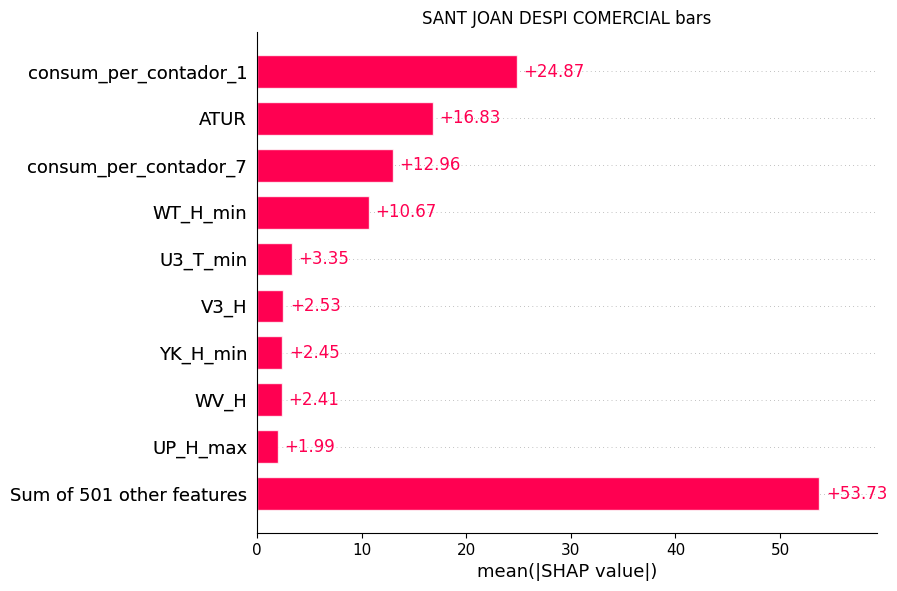

In [29]:
X = model_COMERCIAL_name2df[random_city].drop(columns=['consum_per_contador'])
shap_values = explainer(X)

shap.plots.bar(shap_values, show=False)
plt.title(f"{random_city} COMERCIAL bars")
plt.show()

SHAP també dóna explicacions globals i importància de les features, les quals es poden obtenir fent un bar plot dels shap values. Aquestes s’obtenen a partir de les explicacions locals com les que hem vist prèviament a la notebook i s’ajunten per obtenir una explicació global.

Per tant, el que ens diu la figura es que pel consum comercial de Sant Joan Despí, els millors predictors de consum d’aigua son el consum del dia anterior, l’atur , el consum de fa una setmana i la humitat mínima del dia mesurada des de l’estació WT. La darrera barra, donat que tenim més de 500 variables, representa  l’impacte agregat de les 501 variables restants.

### Domestic

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


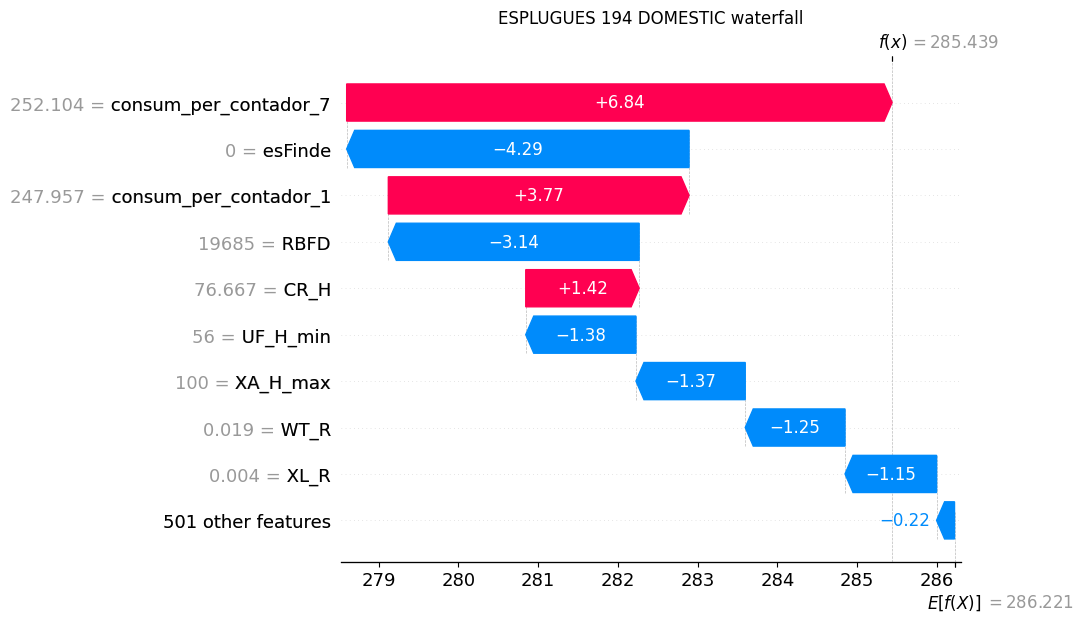

Real value: 258.8400784890851


In [30]:
random.seed(0)

# Choose a random city
random_city = random.choice(list(model_DOMESTIC_name2df.keys()))

X = model_DOMESTIC_name2df[random_city].drop(columns = ['consum_per_contador'])
y = model_DOMESTIC_name2df[random_city].consum_per_contador
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42)

# Choose a random index in the city
random_index = random.choice(list(range(len(X_test))))


model = load_model('DOMESTIC', random_city)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[random_index], show=False)
plt.title(f"{random_city} {random_index} DOMESTIC waterfall")
plt.show()
print(f"Real value: {y_test[random_index]}")

Podem veure que la mesura més rellevant per predir el consum domèstic d’esplugues és el consum de fa una setmana, seguit per si es cap de setmana o no i pel consum del dia anterior. Concretament podem veure que, ja que no es cap de setmana, s’espera que el consum sigui menor. El model també espera que, amb una renda familiar aproximada de 20.000, el consum sigui menor.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


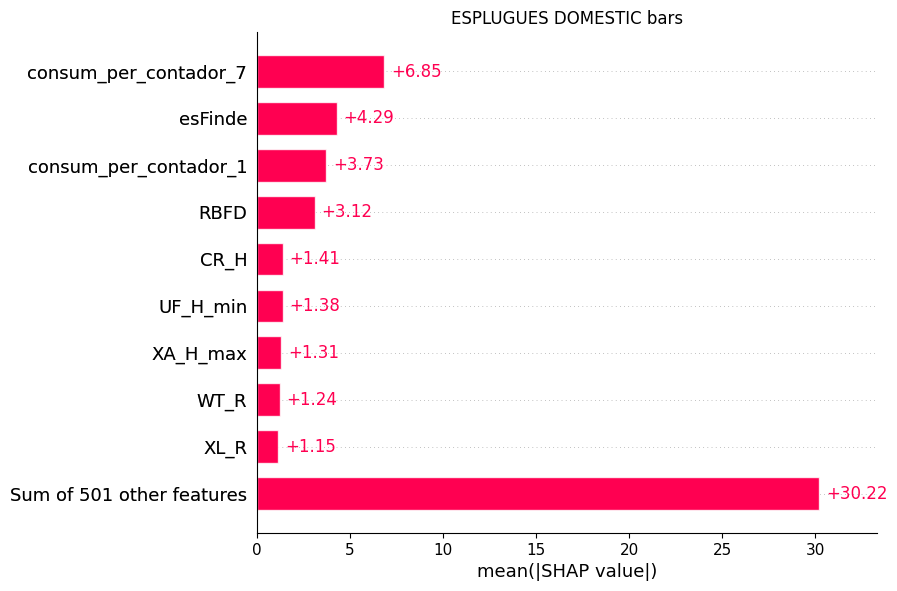

In [31]:
X = model_DOMESTIC_name2df[random_city].drop(columns=['consum_per_contador'])
shap_values = explainer(X)

shap.plots.bar(shap_values, show=False)
plt.title(f"{random_city} DOMESTIC bars")
plt.show()

Aquí podem veure l’impacte mitjà de les variables més rellevants, així com l’impacte acumulat de la resta de variables del model. Podem veure que les característiques més rellevants son el consum de fa set dies, si es cap de setmana, el consum del dia anterior i la renda familiar. Tot i així, les variables més importants no aconsegueixen explicar gran part de la variança del model, sinó que la rellevància de les variables està més distribuida.

### Industrial

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


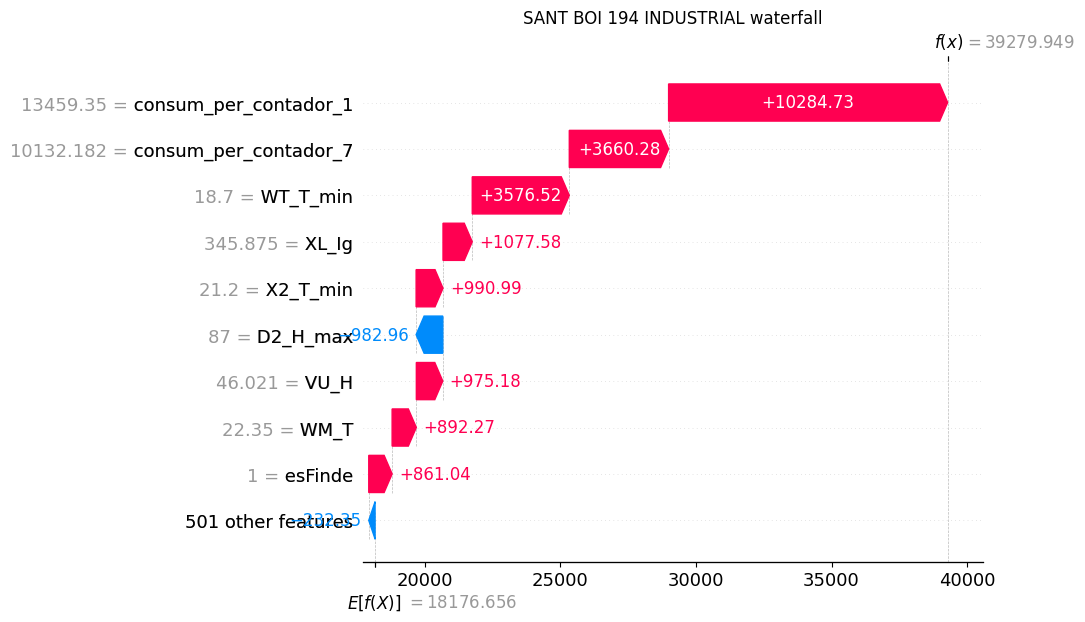

Real value: 18617.41346153846


In [32]:
random.seed(0)

# Choose a random city
random_city = random.choice(list(model_INDUSTRIAL_name2df.keys()))

X = model_INDUSTRIAL_name2df[random_city].drop(columns = ['consum_per_contador'])
y = model_INDUSTRIAL_name2df[random_city].consum_per_contador
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state = 42)

# Choose a random index in the city
random_index = random.choice(list(range(len(X_test))))


model = load_model('INDUSTRIAL', random_city)

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[random_index], show=False)
plt.title(f"{random_city} {random_index} INDUSTRIAL waterfall")
plt.show()
print(f"Real value: {y_test[random_index]}")

Com podem veure, per aquest dia en concret a Sant Boi, el model dóna molta importància al consum del dia anterior i de la setmana passada. Cal mencionar, però, que la predicció de consum industrial no és gaire bona en aquest cas.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


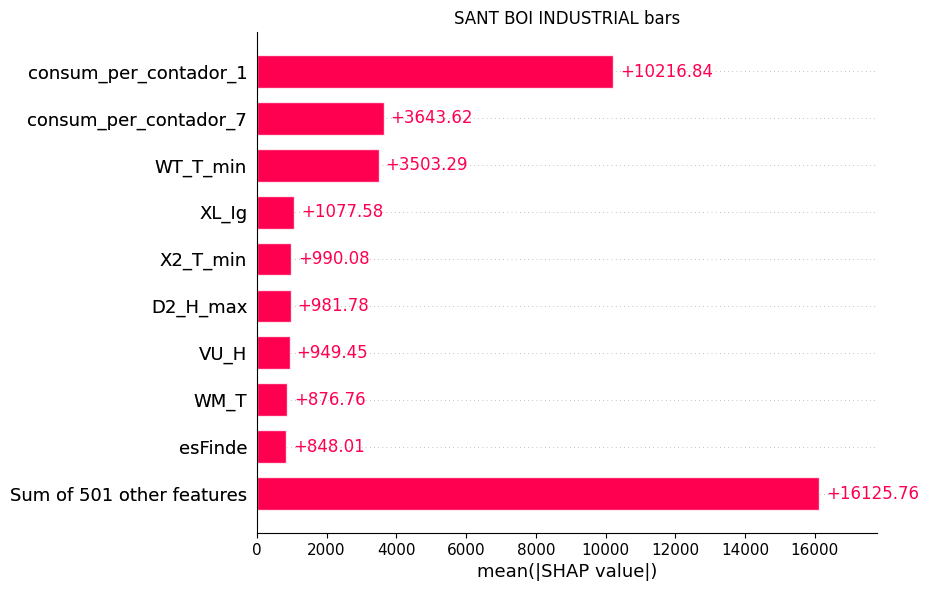

In [33]:
X = model_INDUSTRIAL_name2df[random_city].drop(columns=['consum_per_contador'])
shap_values = explainer(X)

shap.plots.bar(shap_values, show=False)
plt.title(f"{random_city} INDUSTRIAL bars")
plt.show()

Aquí podem veure que el consum industrial de sant boi s’explica pel consum del dia anterior, el consum de la setmana passada, i la temperatura mínima de la estació de la XEMA amb el codi WT.

## Conclusions

Com hem mostrat a la secció ‘Model’, hem aconseguit un error global de 4,89% pel consum comercial, 4.17% pel consum domèstic, i 3.15% pel consum industrial. Si recordem en el video de presentació que vam fer, vam presentar un error del 9% utilitzant només autoregressió i ara al utilitzar en el nostre model també dades externes hem aconseguit reduir-ho a un error per sota de 5%

Les nostres prediccions estan fetes a mesura, és a dir, per a cada municipi tenim un model concret per la predicció del consum en la població, també dividit entre si el consum és domèstic, industrial o comercial. 

Hem decidit fer-ho d’aquesta manera perquè els patrons de consum d’una gran ciutat com pot ser Barcelona o L'hospitalet, son molt diferents als d’un poble com el Papiol, així que si haguéssim fet un mateix model per a totes les poblacions, les prediccions no haurien sigut encertades. 

Cal mencionar que hem tingut en compte factors sorpresa, és a dir, un festiu que cau en dimecres, un augment sobtat de les temperatures, els ponts, etcetera. Aleshores el nostre model es robust envers aquests canvis i d’altres i per tant pot predir el consum tenint-los en compte.

També creiem que aquest projecte té el potencial de utilitzar-lo per fer forecasting: predir quan es consumirà avui, demà, etc i amb aquesta informació predir quan es consumirà d’aquí una setmana utilitzant les prediccions anteriors. D’aquesta manera es podria predir a llarg termini el qual ajudaria a aplicar mesures per gestionar millor a quina potència van les dessalinitzadores, de tal manera que també es podria reduir un gast energètic i sobretot medioambiental


## Time

In [34]:
end_running_time = time.perf_counter()
print(f"Total running time: {end_running_time - start_running_time}")

Total running time: 703.5085116570008
